# Causal Inference

## Replication of the IPW approach for Causal Inference

- [van der Wal W.M and Geskus R.B (2023)](https://cran.r-project.org/web/packages/ipw/index.html)
- [van der Wal W.M and Geskus R.B (2011)](https://www.jstatsoft.org/article/view/v043i13) 

In [1]:
import pandas as pd
import numpy as np

Often, treatment will be constant after a certain switch is made. Example, after a switch from exposure level 0 to exposure level 1 subjects will always remain on exposure level 1. When treatment is deterministically constant after such a switch, these elements in the numerator and denominator of IPW can be set to 1 after the switch. Accordingly, the following function is used to add an indicator variable for identifying observations to be included in the probability models.

In [2]:
def determine_eligibility(df, obs_id: str, obs_time: str, outcome: str):
    def eligibility_group(outcome_series):
        outcome_list = outcome_series.tolist()
        if 1 in outcome_list:
            match_index = outcome_list.index(1)  # Find first occurrence of 1
            return [1] * (match_index + 1) + [0] * (len(outcome_list) - match_index - 1)
        else:
            return [1] * len(outcome_list)  # If no 1 is found, return all 1s
    df = df.copy()       
    df.sort_values(by=[f"{obs_id}", f"{obs_time}"], ascending=[True, True], inplace=True)
    df['is_eligible'] = df.groupby(f"{obs_id}")[f"{outcome}"].transform(lambda x: eligibility_group(x))
    
    return df


### Causal effect of HAART use on mortality in HIV-infected patients

#### Reading data

In [3]:
data_link = "https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/HAARTonMortality.csv"
data_df = pd.read_csv(data_link)
data_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor
0,1,-100,0,1,22,0,23.832751,0,2900,0
1,1,0,100,1,22,0,25.592968,0,2900,0
2,1,100,200,1,22,0,23.473389,0,2900,0
3,1,200,300,1,22,0,24.166092,0,2900,0
4,1,300,400,1,22,0,23.237900,0,2900,0
...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1
19172,1200,-100,0,0,26,0,21.817424,0,200,0
19173,1200,0,100,0,26,0,21.977261,0,200,0


#### Eligibility indicator for IPW models

In [4]:
data_df = determine_eligibility(data_df, "subject_id", "tend", outcome = "haart_treat")
data_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,-100,0,1,22,0,23.832751,0,2900,0,1
1,1,0,100,1,22,0,25.592968,0,2900,0,1
2,1,100,200,1,22,0,23.473389,0,2900,0,1
3,1,200,300,1,22,0,24.166092,0,2900,0,1
4,1,300,400,1,22,0,23.237900,0,2900,0,1
...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0,1
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1,1
19172,1200,-100,0,0,26,0,21.817424,0,200,0,1
19173,1200,0,100,0,26,0,21.977261,0,200,0,1


#### Data to be used for the IPW models

In [5]:
eligible_df = data_df.copy()[data_df.is_eligible == 1]
eligible_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,-100,0,1,22,0,23.832751,0,2900,0,1
1,1,0,100,1,22,0,25.592968,0,2900,0,1
2,1,100,200,1,22,0,23.473389,0,2900,0,1
3,1,200,300,1,22,0,24.166092,0,2900,0,1
4,1,300,400,1,22,0,23.237900,0,2900,0,1
...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0,1
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1,1
19172,1200,-100,0,0,26,0,21.817424,0,200,0,1
19173,1200,0,100,0,26,0,21.977261,0,200,0,1


The stablized treatment weights are:

$$w_{it}^E=\frac{\prod_{k=0}^{t}P(E_{it}=e_{it}|\bar{E}_{i,t-1}=\bar{e}_{i,t-1}, {\bf X}_i={\bf x}_i)}{\prod_{k=0}^{t}P(E_{it}=e_{it}|\bar{E}_{i,t-1}=\bar{e}_{i,t-1}, \bar{Z}_i=\bar{z}_i,{\bf X}_i={\bf x}_i)}$$

Here, $P(E_{it}=e_{it}|\bar{E}_{i,t-1}=\bar{e}_{i,t-1}, {\bf X}_i={\bf x}_i)$ and $P(E_{it}=e_{it}|\bar{E}_{i,t-1}=\bar{e}_{i,t-1}, \bar{Z}_i=\bar{z}_i,{\bf X}_i={\bf x}_i)$ can be estimated using a Cox model. For time points after the initiation of HAART within each patient, both of these elements are set to 1. For time points up to the time point of the initiation of HAART within each patient, we estimate the elements using:
$$\lambda_E[t|L(t),{\bf X},E(t^-=0)]=\lambda_0(t)\cdot e^{{\bf \beta}' {\bf X}} $$
and
$$\lambda_E[t|L(t),{\bf X},E(t^-=0)]=\lambda_0(t)\cdot \exp^{\alpha Z(t)+{\bf \beta}' {\bf X}} $$

#### Fitting IPW Models

In [6]:
pip install lifelines -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
from lifelines import CoxTimeVaryingFitter

#### Numerator Model

In [8]:
model = CoxTimeVaryingFitter()
model.fit(eligible_df, id_col="subject_id", event_col="haart_treat", 
                start_col="tstart", stop_col="tend", formula="sex+age")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,0.069424,1.071891,0.124365,-0.174328,0.313176,0.840022,1.367762,0.0,0.558227,0.576690,0.794133
age,0.007521,1.007549,0.005123,-0.002521,0.017562,0.997483,1.017717,0.0,1.467986,0.142108,2.814941


#### Denominator model

In [9]:
model = CoxTimeVaryingFitter()
model.fit(eligible_df, id_col="subject_id", event_col="haart_treat", 
                start_col="tstart", stop_col="tend", formula="sex+age+cd4_sqrt")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,-0.007756,0.992274,0.125289,-0.253318,0.237806,0.776221,1.268463,0.0,-0.061903,9.506399e-01,0.073029
age,0.004671,1.004682,0.005193,-0.005507,0.014850,0.994508,1.014961,0.0,0.899490,3.683918e-01,1.440687
cd4_sqrt,-0.092620,0.911539,0.010068,-0.112353,-0.072888,0.893729,0.929705,0.0,-9.199519,3.595570e-20,64.592341


#### Predicted Hazard

Recall a survival model is of the form:
$$\underset{Absolute\ hazard}{\underbrace{\lambda_i(t)}}=\underset{Baseline\ hazard}{\underbrace{\lambda_{i0}(t)}}\underset{Partial\ hazard\ ( Risk)}{\underbrace{e^{\beta_1X_{i1}+\beta_2X_{i2}+\cdots+\beta_k X_{ik}}}}$$

where 
- $\lambda_0(t)$ is the baseline hazard (the hazard rate for an individual with all covariates set to zero),
- Risk (or relative hazard) is derived from the covariates for the individual's relative hazard compared to a reference.

#### Predicted Baseline (Cumulative) Hazard

**Cumulative Baseline Hazard** $H_0(t)$: The accumulated risk over time, defined as:
$$H_0(t)=\int_0^t\lambda_0(u)du$$ is what `baseline_cumulative_hazard_` returns, where $h_0(t)$ is the instantaneous risk of an event occurring at time $t$.

In [10]:
cum_bh_df = model.baseline_cumulative_hazard_
cum_bh_df.rename(columns={cum_bh_df.columns[0]: 'cum_base_hazard'}, inplace=True)
cum_bh_df = cum_bh_df.reset_index().rename(columns={'index': 'tend'})
unique_obs_times = sorted(eligible_df['tend'].unique())
cum_bh_df = cum_bh_df.set_index("tend").reindex(unique_obs_times, method='ffill').reset_index()
cum_bh_df

,tend,cum_base_hazard
0,0,0.021082
1,100,0.056736
2,200,0.097959
3,300,0.126951
4,400,0.162565
5,500,0.195340
6,600,0.216234
7,700,0.235088
8,800,0.253745
9,900,0.266892


In [11]:
if pd.isna(cum_bh_df.loc[cum_bh_df['tend'] == min(data_df['tend'].unique()), 
           'cum_base_hazard'].iloc[0]):
    cum_bh_df.loc[cum_bh_df['tend'] == min(data_df['tend'].unique()), 'cum_base_hazard'] = 0

cum_bh_df['cum_base_hazard'] = np.interp(cum_bh_df['tend'], cum_bh_df['tend'], 
                                         cum_bh_df['cum_base_hazard'], left=None, right=None)

cum_bh_df

,tend,cum_base_hazard
0,0,0.021082
1,100,0.056736
2,200,0.097959
3,300,0.126951
4,400,0.162565
5,500,0.195340
6,600,0.216234
7,700,0.235088
8,800,0.253745
9,900,0.266892


In [12]:
# treat_count = eligible_df.groupby('tend')['haart_treat'].sum().reset_index(name='event_count')
# treat_count

In [13]:
base_hazards_df = cum_bh_df.copy()
base_hazards_df['base_hazard'] = pd.NA
base_hazards_df['base_hazard'] = pd.to_numeric(base_hazards_df['base_hazard'], 
                                               errors='coerce')
base_hazards_df.loc[0,"base_hazard"] = base_hazards_df.loc[0,"cum_base_hazard"]
base_hazards_df.loc[1:, 'base_hazard'] = base_hazards_df['cum_base_hazard'].diff()
base_hazards_df

,tend,cum_base_hazard,base_hazard
0,0,0.021082,0.021082
1,100,0.056736,0.035654
2,200,0.097959,0.041223
3,300,0.126951,0.028992
4,400,0.162565,0.035614
5,500,0.195340,0.032775
6,600,0.216234,0.020894
7,700,0.235088,0.018854
8,800,0.253745,0.018657
9,900,0.266892,0.013148


In [14]:
results_df = data_df[["subject_id", "tend", "haart_treat", "is_eligible"]]
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible
0,1,0,0,1
1,1,100,0,1
2,1,200,0,1
3,1,300,0,1
4,1,400,0,1
5,1,500,0,1
6,1,600,0,1
7,1,700,1,1
8,1,800,1,0
9,1,900,1,0


In [15]:
results_df = results_df.copy().merge(base_hazards_df, on='tend', how='left')
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard
0,1,0,0,1,0.021082,0.021082
1,1,100,0,1,0.056736,0.035654
2,1,200,0,1,0.097959,0.041223
3,1,300,0,1,0.126951,0.028992
4,1,400,0,1,0.162565,0.035614
5,1,500,0,1,0.195340,0.032775
6,1,600,0,1,0.216234,0.020894
7,1,700,1,1,0.235088,0.018854
8,1,800,1,0,0.253745,0.018657
9,1,900,1,0,0.266892,0.013148


#### Predicted Partial Hazard (Risk)

In [16]:
results_df.loc[results_df['is_eligible'] == 1, 'risk'] = model.predict_partial_hazard(data_df)
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk
0,1,0,0,1,0.021082,0.021082,0.849933
1,1,100,0,1,0.056736,0.035654,0.722072
2,1,200,0,1,0.097959,0.041223,0.878698
3,1,300,0,1,0.126951,0.028992,0.824093
4,1,400,0,1,0.162565,0.035614,0.898074
5,1,500,0,1,0.195340,0.032775,0.772822
6,1,600,0,1,0.216234,0.020894,0.699087
7,1,700,1,1,0.235088,0.018854,0.692886
8,1,800,1,0,0.253745,0.018657,NaN
9,1,900,1,0,0.266892,0.013148,NaN


#### Full Partial Hazard

In [17]:
results_df.loc[results_df['is_eligible'] == 1,'hazard'] = results_df.loc[
    results_df['is_eligible'] == 1, 'base_hazard'] * results_df.loc[
    results_df['is_eligible'] == 1, 'risk'
]
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk,hazard
0,1,0,0,1,0.021082,0.021082,0.849933,0.017919
1,1,100,0,1,0.056736,0.035654,0.722072,0.025745
2,1,200,0,1,0.097959,0.041223,0.878698,0.036223
3,1,300,0,1,0.126951,0.028992,0.824093,0.023892
4,1,400,0,1,0.162565,0.035614,0.898074,0.031984
5,1,500,0,1,0.195340,0.032775,0.772822,0.025329
6,1,600,0,1,0.216234,0.020894,0.699087,0.014607
7,1,700,1,1,0.235088,0.018854,0.692886,0.013064
8,1,800,1,0,0.253745,0.018657,NaN,NaN
9,1,900,1,0,0.266892,0.013148,NaN,NaN


#### Survival Probability

The survival probability $S_i(t)$ can be derived from the hazard function using:
$$S_i(t)=e^{-\lambda_i(t)} $$

In [18]:
condition1 = (results_df['is_eligible'] == 1) & (results_df['haart_treat'] == 0)
results_df.loc[condition1, 'survival_prob'] = np.exp(-1 * results_df.loc[condition1, 'hazard'])
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk,hazard,survival_prob
0,1,0,0,1,0.021082,0.021082,0.849933,0.017919,0.982241
1,1,100,0,1,0.056736,0.035654,0.722072,0.025745,0.974584
2,1,200,0,1,0.097959,0.041223,0.878698,0.036223,0.964426
3,1,300,0,1,0.126951,0.028992,0.824093,0.023892,0.976391
4,1,400,0,1,0.162565,0.035614,0.898074,0.031984,0.968522
5,1,500,0,1,0.195340,0.032775,0.772822,0.025329,0.974989
6,1,600,0,1,0.216234,0.020894,0.699087,0.014607,0.985499
7,1,700,1,1,0.235088,0.018854,0.692886,0.013064,NaN
8,1,800,1,0,0.253745,0.018657,NaN,NaN,NaN
9,1,900,1,0,0.266892,0.013148,NaN,NaN,NaN


In [19]:
condition2 = (results_df['is_eligible'] == 1) & (results_df['haart_treat'] == 1)
results_df.loc[condition2, 'survival_prob'] = 1 - np.exp(-1 * results_df.loc[condition2, 'hazard'])
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk,hazard,survival_prob
0,1,0,0,1,0.021082,0.021082,0.849933,0.017919,0.982241
1,1,100,0,1,0.056736,0.035654,0.722072,0.025745,0.974584
2,1,200,0,1,0.097959,0.041223,0.878698,0.036223,0.964426
3,1,300,0,1,0.126951,0.028992,0.824093,0.023892,0.976391
4,1,400,0,1,0.162565,0.035614,0.898074,0.031984,0.968522
5,1,500,0,1,0.195340,0.032775,0.772822,0.025329,0.974989
6,1,600,0,1,0.216234,0.020894,0.699087,0.014607,0.985499
7,1,700,1,1,0.235088,0.018854,0.692886,0.013064,0.012979
8,1,800,1,0,0.253745,0.018657,NaN,NaN,NaN
9,1,900,1,0,0.266892,0.013148,NaN,NaN,NaN


In [20]:
results_df.loc[results_df['is_eligible'] == 0, 'survival_prob'] = 1
results_df.head(50)

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk,hazard,survival_prob
0,1,0,0,1,0.021082,0.021082,0.849933,0.017919,0.982241
1,1,100,0,1,0.056736,0.035654,0.722072,0.025745,0.974584
2,1,200,0,1,0.097959,0.041223,0.878698,0.036223,0.964426
3,1,300,0,1,0.126951,0.028992,0.824093,0.023892,0.976391
4,1,400,0,1,0.162565,0.035614,0.898074,0.031984,0.968522
5,1,500,0,1,0.195340,0.032775,0.772822,0.025329,0.974989
6,1,600,0,1,0.216234,0.020894,0.699087,0.014607,0.985499
7,1,700,1,1,0.235088,0.018854,0.692886,0.013064,0.012979
8,1,800,1,0,0.253745,0.018657,NaN,NaN,1.000000
9,1,900,1,0,0.266892,0.013148,NaN,NaN,1.000000


#### Cumulative Product of Survival Probability

$$F_i(t)=\prod_{k=1}^t S_i(k)$$

In [21]:
results_df['cum_prod_prob'] = results_df.groupby('subject_id')['survival_prob'].cumprod()
results_df

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk,hazard,survival_prob,cum_prod_prob
0,1,0,0,1,0.021082,0.021082,0.849933,0.017919,0.982241,0.982241
1,1,100,0,1,0.056736,0.035654,0.722072,0.025745,0.974584,0.957276
2,1,200,0,1,0.097959,0.041223,0.878698,0.036223,0.964426,0.923222
3,1,300,0,1,0.126951,0.028992,0.824093,0.023892,0.976391,0.901426
4,1,400,0,1,0.162565,0.035614,0.898074,0.031984,0.968522,0.873051
...,...,...,...,...,...,...,...,...,...,...
19170,1199,2300,0,1,0.486263,0.025003,0.908387,0.022713,0.977543,0.692671
19171,1199,2400,0,1,0.499834,0.013572,1.176055,0.015961,0.984166,0.681703
19172,1200,0,0,1,0.021082,0.021082,1.051800,0.022174,0.978070,0.978070
19173,1200,100,0,1,0.056736,0.035654,1.036344,0.036950,0.963725,0.942590


#### Functionalizing the Code

In [22]:
unstablized_weights= 1/results_df["cum_prod_prob"]
data_df["unstablized_weights"] = unstablized_weights
unstablized_weights.describe()

count    19175.000000
mean        13.316039
std         25.642766
min          1.002757
25%          1.156309
50%          1.363580
75%         15.719223
max        402.878997
Name: cum_prod_prob, dtype: float64

In [23]:
model = CoxTimeVaryingFitter()
data_df.loc[:, "unstablized_weights"] = unstablized_weights
model.fit(data_df, id_col="subject_id", event_col="death", 
          start_col="tstart", stop_col="tend",
          weights_col = "unstablized_weights", formula= "haart_treat")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.376055,0.686564,0.162543,-0.694634,-0.057477,0.499257,0.944143,0.0,-2.313576,0.020691,5.594853


In [24]:
help(CoxTimeVaryingFitter.fit)

Help on function fit in module lifelines.fitters.cox_time_varying_fitter:

fit(self, df, event_col, start_col='start', stop_col='stop', weights_col=None, id_col=None, show_progress=False, robust=False, strata=None, initial_point=None, formula: str = None, fit_options: Optional[dict] = None)
    Fit the Cox Proportional Hazard model to a time varying dataset. Tied survival times
    are handled using Efron's tie-method.

    Parameters
    -----------
    df: DataFrame
        a Pandas DataFrame with necessary columns `duration_col` and
       `event_col`, plus other covariates. `duration_col` refers to
       the lifetimes of the subjects. `event_col` refers to whether
       the 'death' events was observed: 1 if observed, 0 else (censored).
    event_col: string
       the column in DataFrame that contains the subjects' death
       observation. If left as None, assume all individuals are non-censored.
    start_col: string
        the column that contains the start of a subject's tim

In [25]:
def get_ipw_probs(data_df: pd.DataFrame,
                  obs_id: str,
                  start_time: str,
                  end_time: str,
                  outcome: str,
                  outcome_type: str = "exposure",
                  formula: list = None):
    
  data_df = determine_eligibility(data_df, f"{obs_id}", f"{end_time}", f"{outcome}")
  # display(data_df.head())
  eligible_df = data_df.copy()[data_df.is_eligible == 1]
  # display(eligible_df)

  model = CoxTimeVaryingFitter()
  if formula is not None:
      model.fit(eligible_df, id_col=f"{obs_id}", event_col=f'{outcome}',
                start_col=f"{start_time}", stop_col=f"{end_time}", formula=f'{formula}')
      display(model.summary)
  else:
      eligible_df["constant"] = 1 + np.random.normal(0, 0.000001, size=len(eligible_df))
      model.fit(eligible_df, id_col=f"{obs_id}", event_col=f'{outcome}',
                start_col=f"{start_time}", stop_col=f"{end_time}", formula="constant")
      print("Constant model for the numerator model")

  cum_bh_df = model.baseline_cumulative_hazard_
  cum_bh_df.rename(columns={cum_bh_df.columns[0]: 'cum_base_hazard'}, inplace=True)
  cum_bh_df = cum_bh_df.reset_index().rename(columns={'index': f"{end_time}"})
  unique_obs_times = sorted(eligible_df[f"{end_time}"].unique())
  cum_bh_df = cum_bh_df.set_index(f"{end_time}").reindex(unique_obs_times, method='ffill').reset_index()
  # print("Cumulative baseline hazards")
  # display(cum_bh_df)

  base_hazards_df = cum_bh_df.copy()
  base_hazards_df['base_hazard'] = pd.NA
  base_hazards_df['base_hazard'] = pd.to_numeric(base_hazards_df['base_hazard'], errors='coerce')
  base_hazards_df.loc[0,"base_hazard"] = base_hazards_df.loc[0,"cum_base_hazard"]
  base_hazards_df.loc[1:, 'base_hazard'] = base_hazards_df['cum_base_hazard'].diff()
  # print("Baseline hazards")
  # display(base_hazards_df)

  results_df = data_df[[f"{obs_id}", f"{end_time}", f'{outcome}', "is_eligible"]]
  # display(display(results_df.head(50)))
  results_df = results_df.copy().merge(base_hazards_df, on=f"{end_time}", how='left')
  # display(results_df.head())
  if formula is not None:
      results_df.loc[results_df['is_eligible'] == 1, 'risk'] = model.predict_partial_hazard(data_df)
  else:
      results_df.loc[results_df['is_eligible'] == 1, 'risk'] = 1
  # print("Predicted risk")
  # display(results_df.head())

  results_df.loc[results_df['is_eligible'] == 1,'hazard'] = results_df.loc[
    results_df['is_eligible'] == 1, 'base_hazard'] * results_df.loc[
    results_df['is_eligible'] == 1, 'risk']
  # print("Predicted hazard")
  # display(results_df.head())

  condition1 = (results_df['is_eligible'] == 1) & (results_df[f'{outcome}'] == 0)
  results_df.loc[condition1, 'survival_prob'] = np.exp(-1 * results_df.loc[condition1, 'hazard'])
  # display(results_df.head())

  condition2 = (results_df['is_eligible'] == 1) & (results_df[f'{outcome}'] == 1)
  if f"{outcome_type}" == "censor":
      results_df.loc[condition2, 'survival_prob'] = np.exp(-1 * results_df.loc[condition2, 'hazard'])
  else:
      results_df.loc[condition2, 'survival_prob'] = 1 - np.exp(-1 * results_df.loc[condition2, 'hazard'])
  # display(results_df.head())
    
  results_df.loc[results_df['is_eligible'] == 0, 'survival_prob'] = 1
  # print("Predicted Probabilities")
  # display(results_df)

  results_df['cum_prod_prob'] = results_df.groupby(f"{obs_id}")['survival_prob'].cumprod()
  # print("cum prod Probabilities")
  # display(results_df)

  return results_df

In [26]:
treat_denom_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="tend",
                                  outcome="haart_treat", 
                                  formula="sex + age + cd4_sqrt")

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,-0.007756,0.992274,0.125289,-0.253318,0.237806,0.776221,1.268463,0.0,-0.061903,9.506399e-01,0.073029
age,0.004671,1.004682,0.005193,-0.005507,0.014850,0.994508,1.014961,0.0,0.899490,3.683918e-01,1.440687
cd4_sqrt,-0.092620,0.911539,0.010068,-0.112353,-0.072888,0.893729,0.929705,0.0,-9.199519,3.595570e-20,64.592341


In [37]:
treat_denom_prob["unstablized_treat_weights"] = 1/treat_denom_prob["cum_prod_prob"]

In [38]:
treat_denom_prob

,subject_id,tend,haart_treat,is_eligible,cum_base_hazard,base_hazard,risk,hazard,survival_prob,cum_prod_prob,unstablized_treat_weights
0,1,0,0,1,0.021082,0.021082,0.849933,0.017919,0.982241,0.982241,1.018080
1,1,100,0,1,0.056736,0.035654,0.722072,0.025745,0.974584,0.957276,1.044630
2,1,200,0,1,0.097959,0.041223,0.878698,0.036223,0.964426,0.923222,1.083163
3,1,300,0,1,0.126951,0.028992,0.824093,0.023892,0.976391,0.901426,1.109354
4,1,400,0,1,0.162565,0.035614,0.898074,0.031984,0.968522,0.873051,1.145409
...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2300,0,1,0.486263,0.025003,0.908387,0.022713,0.977543,0.692671,1.443687
19171,1199,2400,0,1,0.499834,0.013572,1.176055,0.015961,0.984166,0.681703,1.466914
19172,1200,0,0,1,0.021082,0.021082,1.051800,0.022174,0.978070,0.978070,1.022422
19173,1200,100,0,1,0.056736,0.035654,1.036344,0.036950,0.963725,0.942590,1.060907


In [39]:
treat_numer_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="tend",
                                  outcome="haart_treat", 
                                  formula="sex + age")["cum_prod_prob"]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,0.069424,1.071891,0.124365,-0.174328,0.313176,0.840022,1.367762,0.0,0.558227,0.576690,0.794133
age,0.007521,1.007549,0.005123,-0.002521,0.017562,0.997483,1.017717,0.0,1.467986,0.142108,2.814941


In [41]:
censor_denom_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="tend",
                                  outcome="censor",
                                  outcome_type="censor", 
                                  formula="sex + age + cd4_sqrt")["cum_prod_prob"]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,-0.317175,0.728203,0.098880,-0.510976,-0.123373,0.599910,0.883934,0.0,-3.207672,0.001338,9.545555
age,0.002874,1.002878,0.003959,-0.004886,0.010635,0.995126,1.010691,0.0,0.725926,0.467884,1.095776
cd4_sqrt,-0.021280,0.978945,0.007044,-0.035086,-0.007474,0.965522,0.992554,0.0,-3.020934,0.002520,8.632382


In [43]:
censor_numer_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="tend",
                                  outcome="censor",
                                  outcome_type="censor", 
                                  formula="sex + age")["cum_prod_prob"]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex,-0.299868,0.740916,0.098587,-0.493096,-0.106641,0.610733,0.898849,0.0,-3.041652,0.002353,8.731381
age,0.003032,1.003036,0.003952,-0.004714,0.010777,0.995297,1.010836,0.0,0.767140,0.442998,1.174628


In [61]:
unstabilized_treat_weights = treat_denom_prob["unstablized_treat_weights"]
unstabilized_treat_weights.describe()

count    19175.000000
mean        13.316039
std         25.642766
min          1.002757
25%          1.156309
50%          1.363580
75%         15.719223
max        402.878997
Name: unstablized_treat_weights, dtype: float64

In [62]:
stabilized_treat_weights = treat_numer_prob * unstabilized_treat_weights
stabilized_treat_weights.describe()

count    19175.000000
mean         1.038989
std          0.392235
min          0.246862
25%          0.905018
50%          0.985945
75%          1.059763
max          7.114542
dtype: float64

In [63]:
unstabilized_weights = unstabilized_treat_weights / censor_denom_prob
unstabilized_weights.describe()

count    19175.000000
mean        24.376283
std         59.327199
min          1.005937
25%          1.277532
50%          1.855978
75%         22.012470
max       1282.473090
dtype: float64

In [64]:
stabilized_weights = (treat_numer_prob * censor_numer_prob) * unstablized_weights
stabilized_weights.describe()

count    19175.000000
mean         1.034433
std          0.365710
min          0.250989
25%          0.895299
50%          0.986249
75%          1.070094
max          7.081190
dtype: float64

#### Causal Model

The MSM model is:

$$\lambda_{T_{\bar{E}}}(t)=\lambda_0(t)e^{\beta E(t)}$$

In [65]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="tend", formula="haart_treat")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.586168,0.556456,0.436833,-1.442345,0.270009,0.236373,1.309977,0.0,-1.341858,0.179642,2.476802


In [68]:
data_df["unstabilized_treat_w"] = unstabilized_treat_weights
data_df["stabilized_treat_w"] = stabilized_treat_weights
data_df["unstabilized_w"] = unstabilized_weights
data_df["stabilized_w"] = stabilized_weights

In [69]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="tend", formula="haart_treat", 
          weights_col = "unstabilized_treat_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.376055,0.686564,0.162543,-0.694634,-0.057477,0.499257,0.944143,0.0,-2.313576,0.020691,5.594853


In [70]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="tend", formula="haart_treat", 
          weights_col = "stabilized_treat_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.986699,0.372805,0.448525,-1.865792,-0.107607,0.154774,0.897981,0.0,-2.199877,0.027816,5.16796


In [71]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="tend", formula="haart_treat", 
          weights_col = "unstabilized_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.000154,0.999846,0.122819,-0.240875,0.240566,0.78594,1.271969,0.0,-0.001256,0.998998,0.001446


In [72]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="tend", formula="haart_treat", 
          weights_col = "stablized_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.938238,0.391317,0.43105,-1.783081,-0.093395,0.168119,0.910833,0.0,-2.176634,0.029508,5.082754


## Causal effect of tuberculosis on mortality in HIV-infected patients

This example is similar to the previous example but with measurements made at irregular intervals of follow-up time. We estimate the causal effect of active tuberculosis (TB) on mortality in HIV-positive individuals, adjusted for possible confounding by time-varying CD4 count using IPW. Note that these data were simulated by the authors using the algorithm described in [Van der Wal, Prins,
Lumbreras, and Geskus (2009)](https://pubmed.ncbi.nlm.nih.gov/19499549/). Therefore, CD4 count at a certain time point is affected by the TB status right before that time point. TB status at a certain time point is affected by CD4 count at that specific time point.  The simulated datasets `longdata_df` and `fixeddata_df` are used in this example.  

Dataset `fixed_data_df` contains time-fixed variables, measured in 386 HIV-positive
individuals: `subject_id` is the patient ID, `time_to_tb` is the time of first active tuberculosis, measured in days since HIV seroconversion, 
`time_to_death` is the time of death, measured in days since HIV seroconversion, 
`time_to_end` is the individual end time (either death or censoring), measured in days since HIV
seroconversion.

In [4]:
import pandas as pd

In [5]:
fixed_data_link = "https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/TimeFixedForTBonMortality.csv"
fixed_data_df = pd.read_csv(fixed_data_link)
fixed_data_df

,subject_id,time_to_tb,time_to_death,time_to_end
0,1,NaN,1846.0,1846
1,2,NaN,NaN,1126
2,3,3139.0,3333.0,3333
3,4,NaN,2253.0,2253
4,5,2771.0,3309.0,3309
...,...,...,...,...
381,396,NaN,1040.0,1040
382,397,NaN,NaN,335
383,398,NaN,2486.0,2486
384,399,NaN,2782.0,2782


Dataset `long_data_df` contains longitudinal measurements made in the same 386 HIV-positive
individuals as `fixed_data_df`: `subject_id` is the patient ID, fuptime is follow-up time, in days since HIV seroconversion, `cd4count` is CD4 count, measured at `fuptime`.

In [6]:
long_data_link = "https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/LongitudinalCD4ForTBonMortality.csv"
long_data_df = pd.read_csv(long_data_link)
long_data_df

,subject_id,fuptime,cd4count
0,1,4,475
1,1,71,555
2,1,200,456
3,1,280,443
4,1,298,506
...,...,...,...
6286,400,1301,206
6287,400,1338,193
6288,400,1372,183
6289,400,1400,174


We will construct a new dataframe with begining and ending time, which will be used to estimate IPWs and to fit an MSM, to quantify the causal effect of TB on mortality. Let ${\bf T}_{TB}$ be all time points at which the TB-status switches, in any individual. Let ${\bf T}_{end}$ be all individual end times. Then, to be able to compute inverse probability weights using a Cox proportional hazards model and fit the MSM, the dataframe should contain, for each individual, rows corresponding to both ${\bf T}_{tb}$ and ${\bf T}_{end}$.
For each individual we include these time points only up to his or her individual end time. We
also sort the time points chronologically within each individual. The dataframe construction
is done as follows:

In [7]:
obs_times = sorted(pd.concat([fixed_data_df['time_to_tb'], 
                              fixed_data_df['time_to_end']]).dropna().unique())
obs_times[1:20], len(obs_times)

([56.0,
  67.0,
  93.0,
  105.0,
  116.0,
  117.0,
  119.0,
  155.0,
  161.0,
  169.0,
  190.0,
  197.0,
  203.0,
  204.0,
  221.0,
  237.0,
  253.0,
  271.0,
  302.0],
 442)

In [8]:
import numpy as np

In [9]:
obs_times_df = pd.DataFrame({
    'subject_id': np.tile(fixed_data_df['subject_id'].values, len(obs_times)),
    'fuptime': np.repeat(obs_times, len(fixed_data_df))
}).sort_values(by=['subject_id', 'fuptime'])
obs_times_df

,subject_id,fuptime
0,1,19.0
386,1,56.0
772,1,67.0
1158,1,93.0
1544,1,105.0
...,...,...
169067,400,3499.0
169453,400,3533.0
169839,400,3558.0
170225,400,3588.0


In [10]:
data_df = pd.merge(obs_times_df, fixed_data_df, on='subject_id', how='left')
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end
0,1,19.0,NaN,1846.0,1846
1,1,56.0,NaN,1846.0,1846
2,1,67.0,NaN,1846.0,1846
3,1,93.0,NaN,1846.0,1846
4,1,105.0,NaN,1846.0,1846
...,...,...,...,...,...
170607,400,3499.0,NaN,1522.0,1522
170608,400,3533.0,NaN,1522.0,1522
170609,400,3558.0,NaN,1522.0,1522
170610,400,3588.0,NaN,1522.0,1522


In [11]:
data_df = data_df[data_df['fuptime'] <= data_df['time_to_end']]
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end
0,1,19.0,NaN,1846.0,1846
1,1,56.0,NaN,1846.0,1846
2,1,67.0,NaN,1846.0,1846
3,1,93.0,NaN,1846.0,1846
4,1,105.0,NaN,1846.0,1846
...,...,...,...,...,...
170363,400,1514.0,NaN,1522.0,1522
170364,400,1516.0,NaN,1522.0,1522
170365,400,1518.0,NaN,1522.0,1522
170366,400,1521.0,NaN,1522.0,1522


We compute the starting time for each interval of follow-up using the following function:

In [12]:
def get_start_times(df, obs_id: str, obs_time: str):
    tstart_list = []
    for _, subdf in df.groupby(f'{obs_id}'):
        keep = [True] * len(subdf)

        if len(subdf) > 1:
            for i in range(1, len(subdf)):
                if subdf[f'{obs_time}'].iloc[i] <= subdf[f'{obs_time}'].iloc[i - 1]:
                    keep[i] = False
        
        subdf = subdf[keep]
        
        tstart = [0] + list(subdf[f'{obs_time}'].iloc[:-1])
        tstart_list.extend(tstart)
    
    return tstart_list

In [13]:
data_df = data_df.copy()
data_df["tstart"] = get_start_times(data_df, "subject_id", "fuptime")
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end,tstart
0,1,19.0,NaN,1846.0,1846,0.0
1,1,56.0,NaN,1846.0,1846,19.0
2,1,67.0,NaN,1846.0,1846,56.0
3,1,93.0,NaN,1846.0,1846,67.0
4,1,105.0,NaN,1846.0,1846,93.0
...,...,...,...,...,...,...
170363,400,1514.0,NaN,1522.0,1522,1510.0
170364,400,1516.0,NaN,1522.0,1522,1514.0
170365,400,1518.0,NaN,1522.0,1522,1516.0
170366,400,1521.0,NaN,1522.0,1522,1518.0


Then we compute `tb`, the TB status at each time point for each individual, and `tb_lag`, the
time-varying TB status one day before each time point for each individual. We also compute
`event`, an indicator for death.

In [14]:
data_df = data_df.copy()
data_df['tb'] = np.where((~data_df['time_to_tb'].isna()) & 
                         (data_df['fuptime'] >= data_df['time_to_tb']), 1, 0)
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end,tstart,tb
0,1,19.0,NaN,1846.0,1846,0.0,0
1,1,56.0,NaN,1846.0,1846,19.0,0
2,1,67.0,NaN,1846.0,1846,56.0,0
3,1,93.0,NaN,1846.0,1846,67.0,0
4,1,105.0,NaN,1846.0,1846,93.0,0
...,...,...,...,...,...,...,...
170363,400,1514.0,NaN,1522.0,1522,1510.0,0
170364,400,1516.0,NaN,1522.0,1522,1514.0,0
170365,400,1518.0,NaN,1522.0,1522,1516.0,0
170366,400,1521.0,NaN,1522.0,1522,1518.0,0


In [15]:
data_df = data_df.copy()
data_df['prev_tb'] = np.where((~data_df['time_to_tb'].isna()) & 
                              (data_df['fuptime'] > data_df['time_to_tb']), 1, 0)
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end,tstart,tb,prev_tb
0,1,19.0,NaN,1846.0,1846,0.0,0,0
1,1,56.0,NaN,1846.0,1846,19.0,0,0
2,1,67.0,NaN,1846.0,1846,56.0,0,0
3,1,93.0,NaN,1846.0,1846,67.0,0,0
4,1,105.0,NaN,1846.0,1846,93.0,0,0
...,...,...,...,...,...,...,...,...
170363,400,1514.0,NaN,1522.0,1522,1510.0,0,0
170364,400,1516.0,NaN,1522.0,1522,1514.0,0,0
170365,400,1518.0,NaN,1522.0,1522,1516.0,0,0
170366,400,1521.0,NaN,1522.0,1522,1518.0,0,0


In [16]:
data_df = data_df.copy()
data_df['death'] = np.where((~data_df['time_to_death'].isna()) & 
                            (data_df['fuptime'] >= data_df['time_to_death']), 1, 0)
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end,tstart,tb,prev_tb,death
0,1,19.0,NaN,1846.0,1846,0.0,0,0,0
1,1,56.0,NaN,1846.0,1846,19.0,0,0,0
2,1,67.0,NaN,1846.0,1846,56.0,0,0,0
3,1,93.0,NaN,1846.0,1846,67.0,0,0,0
4,1,105.0,NaN,1846.0,1846,93.0,0,0,0
...,...,...,...,...,...,...,...,...,...
170363,400,1514.0,NaN,1522.0,1522,1510.0,0,0,0
170364,400,1516.0,NaN,1522.0,1522,1514.0,0,0,0
170365,400,1518.0,NaN,1522.0,1522,1516.0,0,0,0
170366,400,1521.0,NaN,1522.0,1522,1518.0,0,0,0


We also impute time-varying CD4 count `cd4_sqrt` at time points other than the measurement times. We smooth time-varying CD4 using a random effects (LME) model, because it is the underlying "true" CD4, separate from short-term fluctuations and measurement error, that is a confounder for the effect of TB.

Let us prepare the data used to fit an LME model:

In [17]:
lme_data_df = long_data_df.merge(fixed_data_df[['subject_id', 'time_to_tb']], 
                                 on='subject_id', how='left')
lme_data_df

,subject_id,fuptime,cd4count,time_to_tb
0,1,4,475,NaN
1,1,71,555,NaN
2,1,200,456,NaN
3,1,280,443,NaN
4,1,298,506,NaN
...,...,...,...,...
6286,400,1301,206,NaN
6287,400,1338,193,NaN
6288,400,1372,183,NaN
6289,400,1400,174,NaN


Some data processing is necessary. We check if there is more than one CD4 measurement taken on the same day within each patient which is not the case.

In [150]:
dup_rows = lme_data_df.duplicated(subset=["subject_id", "fuptime"])
dup_rows.value_counts()

False    6291
Name: count, dtype: int64

Because of skewness, we compute the square root of CD4 count:

In [151]:
lme_data_df['cd4_sqrt'] = np.sqrt(lme_data_df['cd4count'])
lme_data_df['cd4count'].describe(), lme_data_df['cd4_sqrt'].describe()

(count    6291.000000
 mean      357.917342
 std       176.406665
 min         0.000000
 25%       230.000000
 50%       350.000000
 75%       472.000000
 max      1154.000000
 Name: cd4count, dtype: float64,
 count    6291.000000
 mean       18.238563
 std         5.027541
 min         0.000000
 25%        15.165751
 50%        18.708287
 75%        21.725561
 max        33.970576
 Name: cd4_sqrt, dtype: float64)

Add the time of first active TB to `fixed_data_df`, and compute `prev_tb`, the time-varying TB status
one day before the measurement time:

In [152]:
lme_data_df['prev_tb'] = lme_data_df.apply(lambda row: 1 if pd.notna(row['time_to_tb']) 
                                          and 
                                          row['fuptime'] > row['time_to_tb'] else 0, axis=1)
lme_data_df

,subject_id,fuptime,cd4count,time_to_tb,cd4_sqrt,prev_tb
0,1,4,475,NaN,21.794495,0
1,1,71,555,NaN,23.558438,0
2,1,200,456,NaN,21.354157,0
3,1,280,443,NaN,21.047565,0
4,1,298,506,NaN,22.494444,0
...,...,...,...,...,...,...
6286,400,1301,206,NaN,14.352700,0
6287,400,1338,193,NaN,13.892444,0
6288,400,1372,183,NaN,13.527749,0
6289,400,1400,174,NaN,13.190906,0


To smooth the original measurements, we
fit the random effects  (LME) model
$$\sqrt{Z_i(t)}=\alpha_{0i}+\alpha_{1i}t+\alpha_2E_i(t-1)$$
with $t$ follow-up time (days since HIV seroconversion), $Z(t)$ CD4 count, and $E(t)$ time-varying TB status. Random effects $\alpha_{0i}$ and $\alpha_{1i}$ are assumed to be normally distributed with mean
${\bf \beta}'=(\beta_0,\beta_1)$) and covariance matrix $\Sigma$. The model includes a fixed effect for TB, $\alpha_2$. Because CD4 is affected by the TB status right before $t$, we include $E(t − 1)$, the TB
status one day before $t$ in the above equation. We can fit the model using:

In [153]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

cd4_lme = smf.mixedlm("cd4_sqrt ~ fuptime + prev_tb", lme_data_df, 
                      groups=lme_data_df["subject_id"], re_formula="~fuptime").fit(method="powell")
cd4_lme.summary()

C:\Users\A0087953\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   cd4_sqrt  
No. Observations:    6291      Method:               REML      
No. Groups:          386       Scale:                0.2935    
Min. group size:     1         Log-Likelihood:       -6827.8603
Max. group size:     45        Converged:            Yes       
Mean group size:     16.3                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           24.048    0.158 151.822 0.000 23.737 24.358
fuptime             -0.005    0.000 -49.979 0.000 -0.006 -0.005
prev_tb             -4.031    0.050 -81.218 0.000 -4.128 -3.934
Group Var            9.573    1.332                            
Group x fuptime Cov -0.004    0.001                            
fuptime Var          0.000    0.000                            
===============================================================

"""

In [154]:
# new_data = pd.DataFrame({
#     'subject_id': lme_data_df['subject_id'],
#     'fuptime': lme_data_df['fuptime'],
#     'prev_tb': lme_data_df['prev_tb']
# })

# lme_data_df['pred_cd4_sqrt'] = cd4_lme.predict(new_data)
# lme_data_df

In [155]:
new_data = pd.DataFrame({
    'subject_id': data_df['subject_id'],
    'fuptime': data_df['fuptime'],
    'prev_tb': data_df['prev_tb']
})
new_data

,subject_id,fuptime,prev_tb
0,1,19.0,0
1,1,56.0,0
2,1,67.0,0
3,1,93.0,0
4,1,105.0,0
...,...,...,...
170363,400,1514.0,0
170364,400,1516.0,0
170365,400,1518.0,0
170366,400,1521.0,0


In [156]:
new_data = pd.DataFrame({
    'subject_id': data_df['subject_id'],
    'fuptime': data_df['fuptime'],
    'prev_tb': data_df['tb']
})

data_df['pred_cd4_sqrt'] = cd4_lme.predict(new_data)
data_df

,subject_id,fuptime,time_to_tb,time_to_death,time_to_end,tstart,tb,prev_tb,death,pred_cd4_sqrt
0,1,19.0,NaN,1846.0,1846,0.0,0,0,0,23.945916
1,1,56.0,NaN,1846.0,1846,19.0,0,0,0,23.747292
2,1,67.0,NaN,1846.0,1846,56.0,0,0,0,23.688241
3,1,93.0,NaN,1846.0,1846,67.0,0,0,0,23.548668
4,1,105.0,NaN,1846.0,1846,93.0,0,0,0,23.484249
...,...,...,...,...,...,...,...,...,...,...
170363,400,1514.0,NaN,1522.0,1522,1510.0,0,0,0,15.920428
170364,400,1516.0,NaN,1522.0,1522,1514.0,0,0,0,15.909691
170365,400,1518.0,NaN,1522.0,1522,1516.0,0,0,0,15.898955
170366,400,1521.0,NaN,1522.0,1522,1518.0,0,0,0,15.882850


In [157]:
data_df["pred_cd4_sqrt"].describe()

count    84494.000000
mean        17.155222
std          4.204313
min          0.916734
25%         14.234807
50%         17.514789
75%         20.682038
max         23.945916
Name: pred_cd4_sqrt, dtype: float64

Note that for each row in the above dataframe, `pred_cd4_sqrt` contains imputed CD4 count that predicts
`tb` in the same row. To correct for confounding by time-varying CD4 count, we can estimate
the stabilized inverse probability weights:
$$w_{it}^E=\frac{\prod_{k=0}^{t}P(E_{it}=e_{it}|\bar{E}_{i,t-1}=\bar{e}_{i,t-1})}{\prod_{k=0}^{t}P(E_{it}=e_{it}|\bar{E}_{i,t-1}=\bar{e}_{i,t-1}, \bar{Z}_i=\bar{z}_i)}$$
For time points up to the time point of the first instance of active TB within each patient, we
estimate the elements in the denominator using Cox proportional hazards model:
$$\lambda_E[t|L(t),{\bf X},E(t^-=0)]=\lambda_0(t)\cdot \exp^{\alpha Z(t)} $$
We estimate the numerator using a similar model but only including the constant.

**Note**: The CD4 predictions using the model here and the one is R are different. On top of that when I tried to derive the weights, it fails saying singular matrix. Hence, I decided to use the final data already generated by R.

In [175]:
data = pd.read_csv("https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/merged_tb2death.csv")
data_df = data
data_df

,subject_id,tstart,fuptime,time_to_tb,time_to_death,time_to_death.1,tb,prev_tb,death,pred_cd4_sqrt
0,1,-1,19,NaN,1846.0,1846,0,0,0,22.817813
1,1,19,56,NaN,1846.0,1846,0,0,0,22.656437
2,1,56,67,NaN,1846.0,1846,0,0,0,22.608460
3,1,67,93,NaN,1846.0,1846,0,0,0,22.495061
4,1,93,105,NaN,1846.0,1846,0,0,0,22.442722
...,...,...,...,...,...,...,...,...,...,...
84489,400,1510,1514,NaN,1522.0,1522,0,0,0,12.311262
84490,400,1514,1516,NaN,1522.0,1522,0,0,0,12.292661
84491,400,1516,1518,NaN,1522.0,1522,0,0,0,12.274059
84492,400,1518,1521,NaN,1522.0,1522,0,0,0,12.246157


In [176]:
from lifelines import CoxTimeVaryingFitter

In [177]:
treat_numer_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="fuptime",
                                  outcome="tb")["cum_prod_prob"]
treat_numer_prob.describe()

C:\Users\A0087953\AppData\Local\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['constant'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Constant model for the numerator model


count    84494.000000
mean         0.790463
std          0.286556
min          0.002589
25%          0.763666
50%          0.895721
75%          0.966337
max          0.997411
Name: cum_prod_prob, dtype: float64

In [178]:
# data_df['cd4_normalized'] = data_df.groupby('subject_id')['pred_cd4_sqrt'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# data_df['cd4_standardized'] = data_df.groupby('subject_id')['pred_cd4_sqrt'].transform(lambda x: (x - x.mean()) / x.std())

In [179]:
data_df.pred_cd4_sqrt.describe()

count    84494.000000
mean        17.452117
std          4.736575
min         -4.163422
25%         14.491392
50%         17.869732
75%         20.711036
max         32.824145
Name: pred_cd4_sqrt, dtype: float64

In [180]:
treat_denom_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="fuptime", 
                                  outcome="tb",
                                  formula="pred_cd4_sqrt")["cum_prod_prob"]
treat_denom_prob.describe()

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pred_cd4_sqrt,-0.27934,0.756283,0.037687,-0.353206,-0.205474,0.702432,0.814261,0.0,-7.412006,1.244035e-13,42.870038


count    84494.000000
mean         0.803558
std          0.291109
min          0.000482
25%          0.796748
50%          0.921982
75%          0.976847
max          0.999847
Name: cum_prod_prob, dtype: float64

In [181]:
data_df["treat_numer_prob"] = list(treat_numer_prob)
data_df["treat_denom_prob"] = list(treat_denom_prob)

In [182]:
data_df["unstablized_treat_w"] = 1/data_df["treat_denom_prob"]
data_df["stablized_treat_w"] = data_df["treat_numer_prob"]/data_df["treat_denom_prob"]

In [183]:
data_df["censor"] = 1-data_df["death"] 
censor_numer_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="fuptime",
                                  outcome="censor",
                                 outcome_type="censor")["cum_prod_prob"]

Constant model for the numerator model


C:\Users\A0087953\AppData\Local\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['constant'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [184]:

censor_denom_prob = get_ipw_probs(data_df=data_df,
                                  obs_id="subject_id",
                                  start_time="tstart",
                                  end_time="fuptime",
                                  outcome="censor",
                                 outcome_type="censor",
                                 formula="pred_cd4_sqrt")["cum_prod_prob"]
censor_numer_prob.describe(), censor_denom_prob.describe()

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pred_cd4_sqrt,2.039461e-32,1.0,0.016687,-0.032705,0.032705,0.967824,1.033246,0.0,1.222204e-30,1.0,-0.0


(count    8.449400e+04
 mean     3.678794e-01
 std      1.934575e-13
 min      3.678794e-01
 25%      3.678794e-01
 50%      3.678794e-01
 75%      3.678794e-01
 max      3.678794e-01
 Name: cum_prod_prob, dtype: float64,
 count    8.449400e+04
 mean     3.678794e-01
 std      1.934575e-13
 min      3.678794e-01
 25%      3.678794e-01
 50%      3.678794e-01
 75%      3.678794e-01
 max      3.678794e-01
 Name: cum_prod_prob, dtype: float64)

In [185]:
data_df["censor_numer_prob"] = list(censor_numer_prob)
data_df["censor_denom_prob"] = list(censor_denom_prob)

In [186]:
data_df["stablized_w"] = data_df["stablized_treat_w"]* (data_df["censor_numer_prob"]/data_df["censor_denom_prob"])
data_df["stablized_w"].describe()

count    84494.000000
mean         1.037360
std          0.519222
min          0.211791
25%          0.941012
50%          0.990936
75%          1.012515
max         13.661868
Name: stablized_w, dtype: float64

In [187]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="fuptime", formula="tb")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
tb,1.495423,4.461222,0.181115,1.140444,1.850401,3.128158,6.36237,0.0,8.256768,1.496695e-16,52.569069


In [188]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="fuptime", formula="tb", 
          weights_col = "unstablized_treat_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
tb,0.845535,2.329224,0.100783,0.648005,1.043066,1.911723,2.837904,0.0,8.389687,4.874362e-17,54.187564


In [189]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="fuptime", formula="tb", 
          weights_col = "stablized_treat_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
tb,0.812211,2.252884,0.190096,0.43963,1.184793,1.552133,3.270008,0.0,4.272638,0.000019,15.659738


In [190]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="fuptime", formula="tb", 
          weights_col = "stablized_w")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
tb,0.812211,2.252884,0.190096,0.43963,1.184793,1.552133,3.270008,0.0,4.272638,0.000019,15.659738


In [191]:
model = CoxTimeVaryingFitter()
model.fit(data_df, id_col="subject_id", event_col="death",
          start_col="tstart", stop_col="fuptime", formula="tb + pred_cd4_sqrt")
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
tb,0.246178,1.279128,0.242875,-0.229849,0.722205,0.794654,2.058969,0.0,1.01360,3.107737e-01,1.686064
pred_cd4_sqrt,-0.244439,0.783143,0.033132,-0.309376,-0.179502,0.733904,0.835686,0.0,-7.37779,1.609388e-13,42.498553


In [180]:
# help(CoxTimeVaryingFitter())

Help on CoxTimeVaryingFitter in module lifelines.fitters.cox_time_varying_fitter object:

class CoxTimeVaryingFitter(lifelines.fitters.SemiParametricRegressionFitter, lifelines.fitters.mixins.ProportionalHazardMixin)
 |  CoxTimeVaryingFitter(alpha=0.05, penalizer=0.0, l1_ratio: float = 0.0, strata=None)
 |
 |  This class implements fitting Cox's time-varying proportional hazard model:
 |
 |      .. math::  h(t|x(t)) = h_0(t)\exp((x(t)-\overline{x})'\beta)
 |
 |  Parameters
 |  ----------
 |  alpha: float, optional (default=0.05)
 |     the level in the confidence intervals.
 |  penalizer: float, optional
 |      the coefficient of an L2 penalizer in the regression
 |
 |  Attributes
 |  ----------
 |  params_ : Series
 |      The estimated coefficients. Changed in version 0.22.0: use to be ``.hazards_``
 |  hazard_ratios_ : Series
 |      The exp(coefficients)
 |  confidence_intervals_ : DataFrame
 |      The lower and upper confidence intervals for the hazard coefficients
 |  event_obs

# 

In [1]:
# ### Second Data to be used
# data = pd.read_csv("https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/merged_tb2death.csv")
# data = data.copy().rename(columns={"pred_cd4_sqrt": "cd4_sqrt"})
# data_df = data
# data_df

# **Deep Neural Network for Causal Inference (DNN4CI)**

In [73]:
pip install torch -q

Note: you may need to restart the kernel to use updated packages.


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, Dataset

## --- **Load Data** ---

In [75]:
data_link = "https://raw.githubusercontent.com/awolseid/Datasets/refs/heads/main/HAARTonMortality.csv"
data_df = pd.read_csv(data_link)
data_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor
0,1,-100,0,1,22,0,23.832751,0,2900,0
1,1,0,100,1,22,0,25.592968,0,2900,0
2,1,100,200,1,22,0,23.473389,0,2900,0
3,1,200,300,1,22,0,24.166092,0,2900,0
4,1,300,400,1,22,0,23.237900,0,2900,0
...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1
19172,1200,-100,0,0,26,0,21.817424,0,200,0
19173,1200,0,100,0,26,0,21.977261,0,200,0


## --- **Treatment Exposure Model** ---

### --- **Denominator Model** ---

#### --- **Indicator for Eligible Observations** ---

In [76]:
def determine_eligibility(df: pd.DataFrame, obs_id: str, obs_time: str, outcome: str):
    def eligibility_group(outcome_series):
        outcome_list = outcome_series.tolist()
        if 1 in outcome_list:
            match_index = outcome_list.index(1)
            return [1] * (match_index + 1) + [0] * (len(outcome_list) - match_index - 1)
        else:
            return [1] * len(outcome_list)
    df = df.copy()       
    df.sort_values(by=[f"{obs_id}", f"{obs_time}"], ascending=[True, True], inplace=True)
    df['is_eligible'] = df.groupby(f"{obs_id}")[f"{outcome}"].transform(lambda x: eligibility_group(x))

    print("     An 'is_eligible' variable is included in the data frame for identifying eligible cases for IPW model.")
    
    return df

In [77]:
event      = "death"
outcome    = "haart_treat"
# outcome    = "censor"
obs_id     = "subject_id"
start_time = "tstart"
obs_time   = "tend"

data_df = data_df.sort_values([f"{obs_id}", f"{obs_time}"])
data_df = determine_eligibility(data_df, obs_id, obs_time, outcome)
data_df

     An 'is_eligible' variable is included in the data frame for identifying eligible cases for IPW model.


,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,-100,0,1,22,0,23.832751,0,2900,0,1
1,1,0,100,1,22,0,25.592968,0,2900,0,1
2,1,100,200,1,22,0,23.473389,0,2900,0,1
3,1,200,300,1,22,0,24.166092,0,2900,0,1
4,1,300,400,1,22,0,23.237900,0,2900,0,1
...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0,1
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1,1
19172,1200,-100,0,0,26,0,21.817424,0,200,0,1
19173,1200,0,100,0,26,0,21.977261,0,200,0,1


In [78]:
# list(data_df.groupby(f"{obs_id}")[f"{outcome}"])

In [79]:
event_counts = data_df.groupby(f"{obs_id}")[f"{outcome}"].sum()
# event_counts

In [80]:
subjects_with_no_event = event_counts[event_counts == 0]
# subjects_with_no_event

In [81]:
subjects_with_event_at_last_time = event_counts[event_counts == 1]
# subjects_with_event_at_last_time

In [82]:
subjects_multiple_ones = event_counts[event_counts > 1]
# subjects_multiple_ones

In [83]:
824+16

840

In [84]:
824+16+360

1200

#### --- **Eligible Data** ---

In [85]:
eligible_df = data_df[data_df["is_eligible"] == 1].copy().reset_index(drop=True)
eligible_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,-100,0,1,22,0,23.832751,0,2900,0,1
1,1,0,100,1,22,0,25.592968,0,2900,0,1
2,1,100,200,1,22,0,23.473389,0,2900,0,1
3,1,200,300,1,22,0,24.166092,0,2900,0,1
4,1,300,400,1,22,0,23.237900,0,2900,0,1
...,...,...,...,...,...,...,...,...,...,...,...
14384,1199,2200,2300,1,18,0,22.912878,0,2400,0,1
14385,1199,2300,2400,1,18,0,20.124612,0,2400,1,1
14386,1200,-100,0,0,26,0,21.817424,0,200,0,1
14387,1200,0,100,0,26,0,21.977261,0,200,0,1


In [86]:
def subset_eligible_data(df: pd.DataFrame, obs_id: str, obs_time: str, outcome: str):        
    df = df.copy().sort_values([f"{obs_id}", f"{obs_time}"])
    df = determine_eligibility(df, obs_id, obs_time, outcome)
    eligible_df = df[df["is_eligible"] == 1].copy().reset_index(drop=True)
    del df
    print("     A dataframe containing only eligible observations for IPW model is extracted.")
    return eligible_df

In [87]:
elig_df = subset_eligible_data(data_df, obs_id, obs_time, outcome)
elig_df

     An 'is_eligible' variable is included in the data frame for identifying eligible cases for IPW model.
     A dataframe containing only eligible observations for IPW model is extracted.


,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,-100,0,1,22,0,23.832751,0,2900,0,1
1,1,0,100,1,22,0,25.592968,0,2900,0,1
2,1,100,200,1,22,0,23.473389,0,2900,0,1
3,1,200,300,1,22,0,24.166092,0,2900,0,1
4,1,300,400,1,22,0,23.237900,0,2900,0,1
...,...,...,...,...,...,...,...,...,...,...,...
14384,1199,2200,2300,1,18,0,22.912878,0,2400,0,1
14385,1199,2300,2400,1,18,0,20.124612,0,2400,1,1
14386,1200,-100,0,0,26,0,21.817424,0,200,0,1
14387,1200,0,100,0,26,0,21.977261,0,200,0,1


#### --- **Train, Validaiton and Test Split Sets** ---

In [88]:
end_times_data_df = eligible_df.groupby(f"{obs_id}").tail(1).reset_index(drop=True)
end_times_data_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,600,700,1,22,1,26.038433,0,2900,0,1
1,2,100,200,0,21,1,22.891046,0,3300,0,1
2,3,-100,0,0,47,1,30.282008,0,3200,0,1
3,4,900,1000,0,32,1,22.605309,0,3600,0,1
4,5,800,900,0,36,1,21.633308,0,1300,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,800,900,0,27,0,18.248288,0,900,1,1
1196,1197,400,500,1,26,1,22.737634,0,2900,0,1
1197,1198,800,900,0,23,0,15.297059,0,900,1,1
1198,1199,2300,2400,1,18,0,20.124612,0,2400,1,1


In [89]:
subject_outcome_df = end_times_data_df[[f"{obs_id}", f"{outcome}"]].drop_duplicates()
subject_outcome_df

,subject_id,haart_treat
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
1195,1196,0
1196,1197,1
1197,1198,0
1198,1199,0


In [90]:
from sklearn.model_selection import train_test_split

In [91]:
is_val_required = False

train_ids, temp_ids = train_test_split(subject_outcome_df[f"{obs_id}"],
                                       stratify=subject_outcome_df[f"{outcome}"],
                                       test_size=0.2, random_state=42
                                    )
train_df = eligible_df[eligible_df[f"{obs_id}"].isin(train_ids)].copy().reset_index(drop=True)

if is_val_required:
    temp_df = subject_outcome_df[subject_outcome_df[f"{obs_id}"].isin(temp_ids)].reset_index(drop=True)
    val_ids, test_ids = train_test_split(temp_df[f"{obs_id}"], 
                                         stratify=temp_df[f"{outcome}"],
                                         test_size=0.5, random_state=42
                                        )
    val_df   = eligible_df[eligible_df[f"{obs_id}"].isin(val_ids)].copy().reset_index(drop=True)
    test_df  = eligible_df[eligible_df[f"{obs_id}"].isin(test_ids)].copy().reset_index(drop=True)
    
else:
    val_df  = None
    test_df = eligible_df[eligible_df[f"{obs_id}"].isin(temp_ids)].copy().reset_index(drop=True)    

In [92]:
train_df.shape, test_df.shape #, val_df.shape

((11459, 11), (2930, 11))

In [93]:
# del train_df
# del val_df
# del test_df

In [94]:
display(test_df)

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible
0,1,-100,0,1,22,0,23.832751,0,2900,0,1
1,1,0,100,1,22,0,25.592968,0,2900,0,1
2,1,100,200,1,22,0,23.473389,0,2900,0,1
3,1,200,300,1,22,0,24.166092,0,2900,0,1
4,1,300,400,1,22,0,23.237900,0,2900,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2925,1198,400,500,0,23,0,13.453624,0,900,0,1
2926,1198,500,600,0,23,0,13.341664,0,900,0,1
2927,1198,600,700,0,23,0,15.968719,0,900,0,1
2928,1198,700,800,0,23,0,19.287302,0,900,0,1


In [95]:
# train_df

In [96]:
display(val_df)

None

In [97]:
def split_data(df              : pd.DataFrame, 
               obs_id          : str, 
               outcome         : str,
               test_size       : float         = 0.2,
               is_val_required : bool          = False):
    end_times_df = df.groupby(f"{obs_id}").tail(1).reset_index(drop=True)
    subj_outcome_df = end_times_df[[f"{obs_id}", f"{outcome}"]].drop_duplicates()
    train_ids, temp_ids = train_test_split(subj_outcome_df[f"{obs_id}"],
                                           stratify=subj_outcome_df[f"{outcome}"],
                                           test_size=test_size, random_state=42
                                        )
    train_df = df[df[f"{obs_id}"].isin(train_ids)].copy().reset_index(drop=True)
    
    if is_val_required:
        temp_df = subj_outcome_df[subj_outcome_df[f"{obs_id}"].isin(temp_ids)].reset_index(drop=True)
        val_ids, test_ids = train_test_split(temp_df[f"{obs_id}"], 
                                             stratify=temp_df[f"{outcome}"],
                                             test_size=0.5, random_state=42
                                            )
        val_df   = df[df[f"{obs_id}"].isin(val_ids)].copy().reset_index(drop=True)
        test_df  = df[df[f"{obs_id}"].isin(test_ids)].copy().reset_index(drop=True)
        
    else:
        val_df  = None
        test_df = df[df[f"{obs_id}"].isin(temp_ids)].copy().reset_index(drop=True)
        
    return train_df, test_df, val_df

In [98]:
trn_raw_df, tst_raw_df, vld_raw_df = split_data(eligible_df, obs_id, outcome, 
                                                is_val_required = True)

In [99]:
len(trn_raw_df)

11459

#### --- **Variables Encoding and Scaling** ---

In [100]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

In [101]:
def transform_fixed_covs(obs_id    : str,
                         train_df  : pd.DataFrame, 
                         val_df    : pd.DataFrame  = None, 
                         test_df   : pd.DataFrame  = None,
                         quan_covs : list[str]     = None,
                         qual_covs : list[str]     = None
                        ):   
    
    def select_inv_obs(df): 
        return df.sort_values(by=f"{obs_id}").groupby(f"{obs_id}").first().reset_index()
    
    inv_cols = [f"{obs_id}"] + (quan_covs or []) + (qual_covs or [])
    
    if (qual_covs is not None) or (quan_covs is not None): 
        train_inv_df = select_inv_obs(train_df)[inv_cols]
    else: 
        raise Exception("No variable to be encoded or scaled.")
        
    val_inv_df = select_inv_obs(val_df)[inv_cols] if val_df is not None else None
    test_inv_df = select_inv_obs(test_df)[inv_cols] if test_df is not None else None
    print(f"        Time-invariant features: {(quan_covs or []) + (qual_covs or [])}.")
    
    if quan_covs is not None:
        print("            Quantitative features to be scaled: ", quan_covs)
        scaler = StandardScaler()
        
        train_scaled_array = scaler.fit_transform(train_inv_df[quan_covs])
        scaled_names = [name + "_scaled" for name in 
                        scaler.get_feature_names_out(quan_covs).tolist()]
        train_inv_df = train_inv_df.drop(columns=quan_covs)
        train_inv_df[scaled_names] = train_scaled_array
        
        if val_df is not None: 
            val_scaled_array = scaler.transform(val_inv_df[quan_covs])
            val_inv_df = val_inv_df.drop(columns=quan_covs)
            val_inv_df[scaled_names] = val_scaled_array
            
        if test_df is not None: 
            test_scaled_array = scaler.transform(test_inv_df[quan_covs])
            test_inv_df = test_inv_df.drop(columns=quan_covs)
            test_inv_df[scaled_names] = test_scaled_array
        print("            Standardized feature names: ", scaled_names)
    else:
        print("\n            No quantitative features to be scaled.")
    
    if qual_covs is not None:
        print("\n            Qualitative features to be encoded: ", qual_covs)
        encoder = OneHotEncoder(handle_unknown='ignore')
        train_encoded_array = encoder.fit_transform(train_inv_df[qual_covs]).toarray()
        encoded_names = encoder.get_feature_names_out(qual_covs).tolist()
        
        train_inv_df = train_inv_df.drop(columns=qual_covs)
        train_inv_df[encoded_names] = train_encoded_array
        if val_df is not None: 
            val_encoded_array = encoder.transform(val_inv_df[qual_covs]).toarray()
            val_inv_df = val_inv_df.drop(columns=qual_covs)
            val_inv_df[encoded_names] = val_encoded_array
            
        if test_df is not None: 
            test_encoded_array = encoder.transform(test_inv_df[qual_covs]).toarray()
            test_inv_df = test_inv_df.drop(columns=qual_covs)
            test_inv_df[encoded_names] = test_encoded_array
        print("            Encoded feature names: ", encoded_names)
    else:
        print("\n            No qualitative features to be encoded.")        
        
    return train_inv_df, val_inv_df, test_inv_df

In [102]:
quan_fixed_covs = ["age"]
qual_fixed_covs = ["sex"]

train_fixed_df, val_fixed_df, test_fixed_df = transform_fixed_covs(obs_id,
                                                                   train_df,
                                                                   val_df    = val_df,
                                                                   test_df   = test_df,
                                                                   quan_covs = quan_fixed_covs,
                                                                   qual_covs = qual_fixed_covs
                                                                   )

        Time-invariant features: ['age', 'sex'].
            Quantitative features to be scaled:  ['age']
            Standardized feature names:  ['age_scaled']

            Qualitative features to be encoded:  ['sex']
            Encoded feature names:  ['sex_0', 'sex_1']


In [103]:
display(val_fixed_df)

None

In [104]:
def transform_covs(obs_id    : str,
                   obs_time  : str,
                   outcome   : str,
                   train_df  : pd.DataFrame,  
                   val_df    : pd.DataFrame  = None, 
                   test_df   : pd.DataFrame  = None,
                   quan_covs : list[str]     = None,
                   qual_covs : list[str]     = None
                  ):
    if (qual_covs is None) and (quan_covs is None): 
        raise Exception("No variable to be encoded or scaled.")
    else:
        print(f"\n        Time-varying features: {(quan_covs or []) + (qual_covs or [])}.")
    if quan_covs is not None:
        print("            Quantitative features to be scaled: ", quan_covs)
        scaler = StandardScaler()
        train_scaled_array = scaler.fit_transform(train_df[quan_covs])
        scaled_names = [name + "_scaled" for name in scaler.get_feature_names_out(quan_covs).tolist()]
        train_df[scaled_names] = train_scaled_array
        
        if val_df is not None:
            val_scaled_array = scaler.transform(val_df[quan_covs])
            val_df[scaled_names] = val_scaled_array
        if test_df is not None:
            test_scaled_array = scaler.transform(test_df[quan_covs])
            test_df[scaled_names] = test_scaled_array
        print("            Standardized feature names: ", scaled_names)
    else:
        print("\n            No quantitative features to be scaled.")
    
    if qual_covs is not None:
        print("\n            Qualitative features to be encoded: ", qual_covs)
        encoder = OneHotEncoder(handle_unknown='ignore')
        print(encoder, qual_covs)
        print(train_df.columns)
        train_encoded_array = encoder.fit_transform(train_df[qual_covs]).toarray()
        encoded_names = encoder.get_feature_names_out(qual_covs).tolist()
        train_df[encoded_names] = train_encoded_array
        if val_df is not None: 
            val_encoded_array = encoder.transform(val_df[qual_covs]).toarray()
            val_df[encoded_names] = val_encoded_array
        if test_df is not None: 
            test_encoded_array = encoder.transform(test_df[qual_covs]).toarray()
            test_df[encoded_names] = test_encoded_array
        print("            Encoded feature names: ", encoded_names)
    else:
        print("\n            No qualitative features to be encoded.")

    must_cols = ([f"{obs_id}"] + [f"{obs_time}"] + [f"{outcome}"] +
                 (scaled_names if quan_covs is not None else []) +
                 (encoded_names if qual_covs is not None else []))

    return (train_df[must_cols], 
            val_df[must_cols] if val_df is not None else None, 
            test_df[must_cols] if test_df is not None else None)

In [105]:
quan_vary_covs = ["tend", "cd4_sqrt"]
qual_vary_covs = None

train_vary_df, val_vary_df, test_vary_df = transform_covs(obs_id,
                                                          obs_time,
                                                          outcome,
                                                          train_df,
                                                          val_df, 
                                                          test_df,
                                                          quan_covs = quan_vary_covs,
                                                          qual_covs = qual_vary_covs)


        Time-varying features: ['tend', 'cd4_sqrt'].
            Quantitative features to be scaled:  ['tend', 'cd4_sqrt']
            Standardized feature names:  ['tend_scaled', 'cd4_sqrt_scaled']

            No qualitative features to be encoded.


In [106]:
test_vary_df

,subject_id,tend,haart_treat,tend_scaled,cd4_sqrt_scaled
0,1,0,0,-1.147437,0.215737
1,1,100,0,-1.015220,0.547776
2,1,200,0,-0.883003,0.147949
3,1,300,0,-0.750785,0.278617
4,1,400,0,-0.618568,0.103527
...,...,...,...,...,...
2925,1198,500,0,-0.486351,-1.742134
2926,1198,600,0,-0.354133,-1.763254
2927,1198,700,0,-0.221916,-1.267698
2928,1198,800,0,-0.089699,-0.641696


In [107]:
train_transformed_df = pd.merge(train_vary_df, train_fixed_df, on=obs_id, how='inner')
if (val_vary_df is not None) and (val_fixed_df is not None):
    val_transformed_df = pd.merge(val_vary_df, val_fixed_df, on=obs_id, how='inner')
else:
    val_transformed_df = None
test_transformed_df = pd.merge(test_vary_df, test_fixed_df, on=obs_id, how='inner')

In [108]:
display(val_transformed_df)

None

In [109]:
def preprocess_data(obs_id          : str,
                    train_df        : pd.DataFrame,
                    val_df          : pd.DataFrame  = None,
                    test_df         : pd.DataFrame  = None,
                    quan_fixed_covs : list[str]     = None, 
                    quan_vary_covs  : list[str]     = None, 
                    qual_fixed_covs : list[str]     = None, 
                    qual_vary_covs  : list[str]     = None
                    ):

    if quan_fixed_covs is not None or qual_fixed_covs is not None:
        train_fixed_df, val_fixed_df, test_fixed_df = transform_fixed_covs(obs_id = obs_id,
                                                                           train_df = train_df,
                                                                           val_df = val_df,
                                                                           test_df = test_df,
                                                                           quan_covs = quan_fixed_covs,
                                                                           qual_covs = qual_fixed_covs)
    else:
        train_fixed_df = val_fixed_df = test_fixed_df = None
    if quan_vary_covs is not None or qual_vary_covs is not None:
        train_vary_df, val_vary_df, test_vary_df = transform_covs(obs_id = obs_id,
                                                                  obs_time = obs_time,
                                                                  outcome = outcome,
                                                                  train_df = train_df,
                                                                  val_df = val_df, 
                                                                  test_df = test_df,
                                                                  quan_covs = quan_vary_covs,
                                                                  qual_covs = qual_vary_covs)
    else:
        train_vary_df = val_vary_df = test_vary_df = None
    
    if train_vary_df is not None and train_fixed_df is not None:
        train_scaled_df = pd.merge(train_vary_df, train_fixed_df, on=obs_id, how='inner')
    elif train_vary_df is not None and train_fixed_df is None:
        train_scaled_df = train_vary_df
    elif train_vary_df is None and train_fixed_df is not None:
        train_scaled_df = train_fixed_df
    else:
        train_scaled_df = None

    if val_vary_df is not None and val_fixed_df is not None:
        val_scaled_df = pd.merge(val_vary_df, val_fixed_df, on=obs_id, how='inner')
    elif val_vary_df is not None and val_fixed_df is None:
        val_scaled_df = val_vary_df
    elif val_vary_df is None and val_fixed_df is not None:
        val_scaled_df = val_fixed_df
    else:
        val_scaled_df = None
    
    if test_vary_df is not None and test_fixed_df is not None:
        test_scaled_df = pd.merge(test_vary_df, test_fixed_df, on=obs_id, how='inner')
    elif test_vary_df is not None and test_fixed_df is None:
        test_scaled_df = test_vary_df
    elif test_vary_df is None and test_fixed_df is not None:
        test_scaled_df = test_fixed_df
    else:
        test_scaled_df = None
        
    return train_scaled_df, val_scaled_df, test_scaled_df

In [110]:
trn_scaled_df, vld_scaled_df, tst_scaled_df = preprocess_data(
    obs_id          = obs_id, 
    train_df        = train_df, 
    val_df          = val_df, 
    test_df         = test_df,
    quan_fixed_covs = quan_fixed_covs, 
    quan_vary_covs  = quan_vary_covs,
    qual_fixed_covs = qual_fixed_covs, 
    qual_vary_covs  = qual_vary_covs)


        Time-invariant features: ['age', 'sex'].
            Quantitative features to be scaled:  ['age']
            Standardized feature names:  ['age_scaled']

            Qualitative features to be encoded:  ['sex']
            Encoded feature names:  ['sex_0', 'sex_1']

        Time-varying features: ['tend', 'cd4_sqrt'].
            Quantitative features to be scaled:  ['tend', 'cd4_sqrt']
            Standardized feature names:  ['tend_scaled', 'cd4_sqrt_scaled']

            No qualitative features to be encoded.


In [111]:
display(vld_scaled_df)

None

#### --- **Prepare Longitudinal Data into Sequences** ---

In [112]:
encoded_fixed_names = [col_name for col_name in train_transformed_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (qual_fixed_covs or []))]
encoded_vary_names = [col_name for col_name in train_transformed_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (qual_vary_covs or []))]

scaled_fixed_names = [col_name for col_name in train_transformed_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (quan_fixed_covs or []))]
scaled_vary_names = [col_name for col_name in train_transformed_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (quan_vary_covs or []))]

fixed_feature_names = encoded_fixed_names + scaled_fixed_names
vary_feature_names = encoded_vary_names + scaled_vary_names

In [113]:
def get_transformed_feature_names(transformed_df   : pd.DataFrame,
                                  qual_fixed_covs  : list[str]     = None,
                                  qual_vary_covs   : list[str]     = None,
                                  quan_fixed_covs  : list[str]     = None,
                                  quan_vary_covs   : list[str]     = None
                                 ):
    encoded_fixed_names = [col_name for col_name in transformed_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (qual_fixed_covs or []))]
    encoded_vary_names = [col_name for col_name in transformed_df.columns 
                         if any(col_name.startswith(f"{var}_") for var in 
                                (qual_vary_covs or []))]
    
    scaled_fixed_names = [col_name for col_name in transformed_df.columns 
                         if any(col_name.startswith(f"{var}_") for var in 
                                (quan_fixed_covs or []))]
    scaled_vary_names = [col_name for col_name in transformed_df.columns 
                         if any(col_name.startswith(f"{var}_") for var in 
                                (quan_vary_covs or []))]
    return {"fixed_feature_names": encoded_fixed_names + scaled_fixed_names,
            "vary_feature_names": encoded_vary_names + scaled_vary_names}

In [114]:
feature_names = get_transformed_feature_names(
    transformed_df   = train_transformed_df,
    qual_fixed_covs  = qual_fixed_covs,
    qual_vary_covs   = qual_vary_covs,
    quan_fixed_covs  = quan_fixed_covs,
    quan_vary_covs   = quan_vary_covs
)

In [115]:
fixed_feature_names = feature_names["fixed_feature_names"]
fixed_feature_names

['sex_0', 'sex_1', 'age_scaled']

In [116]:
vary_feature_names = feature_names["vary_feature_names"]
vary_feature_names

['tend_scaled', 'cd4_sqrt_scaled']

In [117]:
def prepare_sequences(df,
                      obs_id              : str,
                      obs_time            : str,
                      outcome             : str, 
                      fixed_feature_names : str, 
                      vary_feature_names  : str):
    seq_data = []
    for _, group in df.groupby(obs_id):
        group = group.sort_values(obs_time)
        data = {'static': group[fixed_feature_names].iloc[0].values,
                'longitudinal': group[vary_feature_names].values,  # shape: (T, D)
                'labels': group[outcome].values  # shape: (T,)
               }
        seq_data.append(data)

    return seq_data

In [118]:
len(train_transformed_df)

11459

In [119]:
train_seq_data = prepare_sequences(train_transformed_df,
                                  obs_id,
                                  obs_time,
                                  outcome, 
                                  fixed_feature_names, 
                                  vary_feature_names)

if val_transformed_df is not None: 
    val_seq_data = prepare_sequences(val_transformed_df,
                                      obs_id,
                                      obs_time,
                                      outcome, 
                                      fixed_feature_names, 
                                      vary_feature_names)
else: 
    val_seq_data = None

test_seq_data = prepare_sequences(test_transformed_df,
                                  obs_id,
                                  obs_time,
                                  outcome, 
                                  fixed_feature_names, 
                                  vary_feature_names)

In [120]:
len(test_seq_data)

240

In [121]:
len(train_seq_data), len(test_seq_data) #, len(val_seq_data)

(960, 240)

#### --- **Create Tensor Datasets** ---

In [122]:
class LongitudinalDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

In [123]:
train_dataset = LongitudinalDataset(train_seq_data)
if val_seq_data is not None: 
    val_dataset = LongitudinalDataset(val_seq_data)
else:
    val_dataset = None
test_dataset = LongitudinalDataset(test_seq_data)

In [53]:
train_dataset[2]

{'static': array([ 1.        ,  0.        , -0.42137585]),
 'longitudinal': array([[-1.14743725,  1.13817605],
        [-1.01521993,  1.01192368],
        [-0.88300262,  1.33807907]]),
 'labels': array([0, 0, 1], dtype=int64)}

In [54]:
train_dataset[2]

{'static': array([ 1.        ,  0.        , -0.42137585]),
 'longitudinal': array([[-1.14743725,  1.13817605],
        [-1.01521993,  1.01192368],
        [-0.88300262,  1.33807907]]),
 'labels': array([0, 0, 1], dtype=int64)}

In [124]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    static = torch.tensor(np.array([item['static'] for item in batch]), dtype=torch.float32)
    longit = [torch.tensor(item['longitudinal'], dtype=torch.float32) for item in batch]
    labels = [torch.tensor(item["labels"], dtype=torch.float32) for item in batch]

    padded_longit = pad_sequence(longit, batch_first=True, padding_value=-1.0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1.0)

    return static, padded_longit, padded_labels

In [125]:
train_dataset[0]

{'static': array([ 1.       ,  0.       , -1.3283732]),
 'longitudinal': array([[-1.14743725, -0.87406296],
        [-1.01521993, -0.41869334],
        [-0.88300262,  0.0380981 ]]),
 'labels': array([0, 0, 1], dtype=int64)}

In [57]:
eg_batch = [train_dataset[0], train_dataset[1]]
collate_fn(eg_batch)

(tensor([[ 1.0000,  0.0000, -1.3284],
         [ 1.0000,  0.0000, -0.2198]]),
 tensor([[[-1.1474, -0.8741],
          [-1.0152, -0.4187],
          [-0.8830,  0.0381],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000]],
 
         [[-1.1474, -0.0451],
          [-1.0152,  0.1116],
          [-0.8830, -0.4325],
          [-0.7508, -0.1515],
          [-0.6186, -0.4884],
          [-0.4864, -0.5739],
          [-0.3541,  0.0133],
          [-0.2219,  0.1680],
          [-0.0897, -0.0325],
          [ 0.0425,  0.3828],
          [ 0.1747, -0.0158]]]),
 tensor([[ 0.,  0.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]]))

In [58]:
eg_batch = [train_dataset[0], train_dataset[1], train_dataset[2]]
collate_fn(eg_batch)

(tensor([[ 1.0000,  0.0000, -1.3284],
         [ 1.0000,  0.0000, -0.2198],
         [ 1.0000,  0.0000, -0.4214]]),
 tensor([[[-1.1474, -0.8741],
          [-1.0152, -0.4187],
          [-0.8830,  0.0381],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000]],
 
         [[-1.1474, -0.0451],
          [-1.0152,  0.1116],
          [-0.8830, -0.4325],
          [-0.7508, -0.1515],
          [-0.6186, -0.4884],
          [-0.4864, -0.5739],
          [-0.3541,  0.0133],
          [-0.2219,  0.1680],
          [-0.0897, -0.0325],
          [ 0.0425,  0.3828],
          [ 0.1747, -0.0158]],
 
         [[-1.1474,  1.1382],
          [-1.0152,  1.0119],
          [-0.8830,  1.3381],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
        

In [59]:
eg_batch = [train_dataset[0], train_dataset[1], train_dataset[2], train_dataset[3]]
collate_fn(eg_batch)

(tensor([[ 1.0000,  0.0000, -1.3284],
         [ 1.0000,  0.0000, -0.2198],
         [ 1.0000,  0.0000, -0.4214],
         [ 0.0000,  1.0000, -0.7237]]),
 tensor([[[-1.1474, -0.8741],
          [-1.0152, -0.4187],
          [-0.8830,  0.0381],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000]],
 
         [[-1.1474, -0.0451],
          [-1.0152,  0.1116],
          [-0.8830, -0.4325],
          [-0.7508, -0.1515],
          [-0.6186, -0.4884],
          [-0.4864, -0.5739],
          [-0.3541,  0.0133],
          [-0.2219,  0.1680],
          [-0.0897, -0.0325],
          [ 0.0425,  0.3828],
          [ 0.1747, -0.0158]],
 
         [[-1.1474,  1.1382],
          [-1.0152,  1.0119],
          [-0.8830,  1.3381],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],
          [-1.0000, -1.0000],


### **Model Building**

#### --- **Model Archtecture to be Trained** ---

In [126]:
class LSTM4TreatmentExposureDenominatorModel(nn.Module):
    def __init__(self, longitudinal_input_dim, static_input_dim, hidden_dim):
        super(LSTM4TreatmentExposureDenominatorModel, self).__init__()
        self.lstm = nn.LSTM(longitudinal_input_dim, hidden_dim, batch_first=True)
        self.fc_static = nn.Linear(static_input_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x_static, x_longit):
        lstm_out, _ = self.lstm(x_longit)
        static_proj = self.fc_static(x_static).unsqueeze(1).expand(-1, lstm_out.size(1), -1)
        concat = torch.cat([lstm_out, static_proj], dim=-1)
        logits = self.classifier(concat).squeeze(-1)
        return logits

#### --- **Model Training and Evaluation Loop** ---

In [140]:
def train_model(model, train_loader, val_loader = None, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(reduction='none')

    summaries = {"train_losses": [], "val_losses": [],
                 "train_accuracies": [], "val_accuracies": []
                }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct, total = 0, 0
        
        for x_static, x_longit, y in train_loader:
            x_static, x_longit, y = x_static.to(device), x_longit.to(device), y.to(device)
            optimizer.zero_grad()

            y_pred = model(x_static, x_longit)
            mask = (y != -1)
            loss = criterion(y_pred, y)
            loss = (loss * mask).sum() / mask.sum()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            y_prob = torch.sigmoid(y_pred)
            y_label = (y_prob >= 0.5).float()
            correct += ((y_label == y) * mask).sum().item()
            total += mask.sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        
        summaries["train_losses"].append(avg_train_loss)
        summaries["train_accuracies"].append(train_accuracy)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            correct, total = 0, 0
    
            with torch.inference_mode():
                for x_static, x_longit, y in val_loader:
                    x_static, x_longit, y = x_static.to(device), x_longit.to(device), y.to(device)
    
                    y_pred = model(x_static, x_longit)
                    mask = (y != -1)
                    loss = criterion(y_pred, y)
                    loss = (loss * mask).sum() / mask.sum()
                    val_loss += loss.item()
    
                    y_prob = torch.sigmoid(y_pred)
                    y_label = (y_prob >= 0.5).float()
                    correct += ((y_label == y) * mask).sum().item()
                    total += mask.sum().item()
    
            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = correct / total
    
            summaries["val_losses"].append(avg_val_loss)
            summaries["val_accuracies"].append(val_accuracy)

            if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
                print(f"Epoch {epoch + 1}: "
                      f"Train Loss = {avg_train_loss:.4f}, "
                      f"Val Loss = {avg_val_loss:.4f} | "
                      f"Train Acc = {train_accuracy:.4f}, "
                      f"Val Acc = {val_accuracy:.4f}")
        else:
            if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
                print(f"Epoch {epoch + 1}: "
                      f"Train: Loss = {avg_train_loss:.4f}, "
                      f"Acc = {train_accuracy:.4f}")

    return summaries

#### --- **Model Testing Loop** ---

In [141]:
def test_model(model, test_loader):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_pred_probs, all_true_labels = [], []

    with torch.inference_mode():
        for x_static, x_longit, y in test_loader:
            x_static = x_static.to(device)
            x_longit = x_longit.to(device)
            y = y.to(device)

            logits = model(x_static, x_longit)
            pred_probs = torch.sigmoid(logits)

            mask = (y != -1)

            all_pred_probs.append(pred_probs[mask].cpu())
            all_true_labels.append(y[mask].cpu())

    flat_pred_probs = torch.cat(all_pred_probs).numpy()
    flat_pred_labels = (flat_pred_probs >= 0.5).astype(int)
    
    flat_true_labels = torch.cat(all_true_labels).int().numpy()

    acc = accuracy_score(flat_true_labels, flat_pred_labels)
    print(f"Accuracy : {acc:.4f}")
    
    return flat_pred_probs, flat_pred_labels, flat_true_labels


### --- Train and Evaluate Model ---

In [142]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [143]:
stat_input_dim = len(train_seq_data[0]["static"])
long_input_dim = train_seq_data[0]["longitudinal"].shape[1]

#### --- **Cross-Validation**

In [137]:
def cross_validate_model(model_class, dataset, static_dim, longit_dim, hidden_dim=64, 
                         epochs=10, lr=0.001, batch_size=32, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_val_losses = []
    all_summaries = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        model = model_class(longit_dim, static_dim, hidden_dim)

        summaries = train_model(model, train_loader, val_loader, epochs, lr)

        val_loss = summaries["val_losses"][-1]  # take the last epoch's val loss
        all_val_losses.append(val_loss)
        all_summaries.append(summaries)

    avg_val_loss = np.mean(all_val_losses)
    print(f"\nAverage Validation Loss across {n_splits} folds: {avg_val_loss:.4f}")
    return all_summaries, all_val_losses
    
def grid_search_cv(model_class, dataset, static_dim, longit_dim, 
                   param_grid, epochs=10, n_splits=5):
    grid = ParameterGrid(param_grid)
    
    best_params = None
    best_val_loss = float('inf')  # initialize with large value
    best_model_summaries = None

    for params in grid:
        print(f"\n=== Training with Hyperparameters: {params} ===")
        
        hidden_dim = params['hidden_dim']
        lr = params['lr']
        batch_size = params['batch_size']
        
        summaries, val_losses = cross_validate_model(
            model_class, dataset, static_dim, longit_dim, 
            hidden_dim=hidden_dim, epochs=epochs, 
            lr=lr, batch_size=batch_size, n_splits=n_splits
        )
        
        avg_val_loss = np.mean(val_losses)
        print(f"Average Validation Loss for {params}: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = params
            best_model_summaries = summaries
    
    print(f"\nBest Hyperparameters: {best_params}")
    print(f"     Lowest Validation Loss: {best_val_loss:.4f}")
    
    return best_params, best_model_summaries, best_val_loss


In [138]:
# param_grid = {
#     'hidden_dim' : [16, 32, 64, 128],
#     'lr'         : [0.01, 0.001, 0.0001],
#     'batch_size' : [16, 32, 64, 128]
# }

# best_params, best_model_summaries, best_val_acc = grid_search_cv(
#     LSTM4TreatmentExposureDenominatorModel,
#     dataset                                 = train_dataset,
#     static_dim                              = stat_input_dim,
#     longit_dim                              = long_input_dim,
#     param_grid                              = param_grid,
#     epochs                                  = 15,
#     n_splits                                = 5
# )

Best Hyperparameters: {'batch_size': 68, 'hidden_dim': 128, 'lr': 0.01}
     Lowest Validation Loss: 0.1168

###### --- **Optimal Hyperparameters**

In [184]:
bs = 68
hd = 128
lr = 0.01

#### --- **Dataloaders for the final model**

In [185]:
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True, collate_fn=collate_fn)
if val_dataset is not None:
    val_dl = DataLoader(val_dataset, batch_size=bs, shuffle=False, collate_fn=collate_fn)
else:
    val_dl = None
    
test_dl = DataLoader(test_dataset, batch_size=bs, shuffle=False, collate_fn=collate_fn)

In [186]:
len(train_dl), len(test_dl) #, len(val_dl)

(15, 4)

In [187]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

treat_denom_model = LSTM4TreatmentExposureDenominatorModel(longitudinal_input_dim=long_input_dim,
                                                           static_input_dim=stat_input_dim,
                                                           hidden_dim=hd)
treat_denom_metrics = train_model(treat_denom_model, 
                                  train_loader = train_dl, 
                                  val_loader = val_dl, 
                                  epochs=50, lr=lr)

Epoch 1: Train: Loss = 0.2087, Acc = 0.9469
Epoch 10: Train: Loss = 0.1179, Acc = 0.9737
Epoch 20: Train: Loss = 0.1122, Acc = 0.9737
Epoch 30: Train: Loss = 0.1108, Acc = 0.9737
Epoch 40: Train: Loss = 0.1144, Acc = 0.9737
Epoch 50: Train: Loss = 0.1101, Acc = 0.9737


In [188]:
def plot_training_metrics(metrics):
    epochs_range = range(1, len(metrics["train_losses"]) + 1)
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, metrics["train_losses"], label='Train')
    if metrics["val_losses"] != []:
        plt.plot(epochs_range, metrics["val_losses"], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, metrics["train_accuracies"], label='Train', color='darkorange')
    if metrics["val_accuracies"] != []:
        plt.plot(epochs_range, metrics["val_accuracies"], label='Validation', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

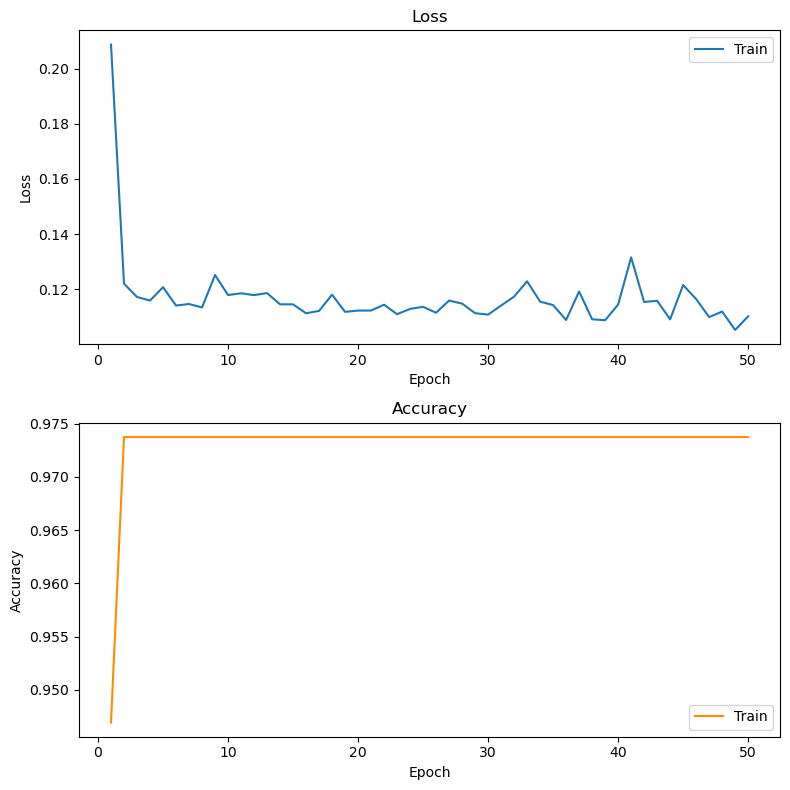

In [189]:
import matplotlib.pyplot as plt
plot_training_metrics(treat_denom_metrics)

#### --- **Test Model** ---

In [190]:
test_model(treat_denom_model, test_dl)

Accuracy : 0.9744


(array([0.02923605, 0.02076127, 0.0266877 , ..., 0.06084305, 0.06357323,
        0.03900364], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]))

#### --- **Deriving Summaries for Determining IPWs** ---

In [191]:
def get_denom_summaries(trained_model   : nn.Module, 
                      df              : pd.DataFrame,
                      obs_id          : str,
                      obs_time        : str,
                      outcome         : str,
                      outcome_type    : str           = "exposure",
                      quan_fixed_covs : list[str]     = None, 
                      quan_vary_covs  : list[str]     = None,
                      qual_fixed_covs : list[str]     = None,
                      qual_vary_covs  : list[str]     = None
                     ):

    print("-----Data processing started...")
    scaled_df, _, _ = preprocess_data(obs_id = obs_id,
                                      train_df = df,
                                      quan_fixed_covs = quan_fixed_covs,
                                      quan_vary_covs = quan_vary_covs,
                                      qual_fixed_covs = qual_fixed_covs,
                                      qual_vary_covs = qual_vary_covs)
    print("-----Data processing completed.")
    print("\n-----Converting data to longitudinal sequences ...")
    encoded_fixed_names = [col_name for col_name in scaled_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (qual_fixed_covs or []))]
    encoded_vary_names = [col_name for col_name in scaled_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (qual_vary_covs or []))]
    scaled_fixed_names = [col_name for col_name in scaled_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (quan_fixed_covs or []))]
    scaled_vary_names = [col_name for col_name in scaled_df.columns 
                     if any(col_name.startswith(f"{var}_") for var in 
                            (quan_vary_covs or []))]

    fixed_feature_names = encoded_fixed_names + scaled_fixed_names
    vary_feature_names = encoded_vary_names + scaled_vary_names
    
    seq_data = prepare_sequences(scaled_df,
                                  obs_id,
                                  obs_time,
                                  outcome, 
                                  fixed_feature_names, 
                                  vary_feature_names)
    print("-----Converting data to longitudinal sequences completed.")
    print("\n-----Creating tensor datasets and dataloaders started...")
    dataset = LongitudinalDataset(seq_data)
    data_loader= DataLoader(dataset, batch_size = 16, collate_fn=collate_fn)
    print("-----Creating tensor datasets and dataloaders completed.")
    print("\n-----Getting predicted probabilities using trained model...")
    pred_probs, _ , _ = test_model(trained_model, data_loader) 
    print("-----Getting predicted probabilities using trained model completed.")
    print("\n-----IPW probabilties are being obtained...")
    IPW_df = df.copy()[[f"{obs_id}", f"{obs_time}", f"{outcome}", "is_eligible"]]

    condition1 = IPW_df['is_eligible'] == 0
    condition2 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 1)
    condition3 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 0)
    
    if outcome_type == "exposure":
        IPW_df["DenomP_it(E)"] = pred_probs
        IPW_df["DenomP_it(E=e)"] = np.nan
        
        IPW_df.loc[condition1, 'DenomP_it(E=e)'] = 1
        IPW_df.loc[condition2, 'DenomP_it(E=e)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'DenomP_it(E)']
        IPW_df.loc[condition3, 'DenomP_it(E=e)'] = 1 - IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'DenomP_it(E)']
        
        IPW_df['DenomTreatProbs'] = IPW_df.groupby(f'{obs_id}')['DenomP_it(E=e)'].cumprod()
        IPW_df["UnstablizedIPTWs"] = 1 / IPW_df['DenomTreatProbs']
    elif outcome_type == "censor":
        IPW_df["DenomP_it(C)"] = pred_probs
        IPW_df["DenomP_it(C=1)"] = np.nan
        IPW_df.loc[condition1, 'DenomP_it(C=1)'] = 1
        IPW_df.loc[condition2, 'DenomP_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'DenomP_it(C)']
        IPW_df.loc[condition3, 'DenomP_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'DenomP_it(C)']
        
        IPW_df['DenomCensorProbs'] = IPW_df.groupby(f'{obs_id}')['DenomP_it(C=1)'].cumprod()
        IPW_df["UnstablizedIPCWs"] = 1 / IPW_df['DenomCensorProbs']       
    else:
        raise Exception("Outcome type must be 'exposure' for treatment or 'censor' for censoring!")
    print("-----IPW probabilties obtained.")
    return IPW_df.drop(columns=[f"{outcome}", "is_eligible"])

In [192]:
denom_treat_df = get_denom_summaries(treat_denom_model,
                                     data_df,
                                     obs_id,
                                     obs_time,
                                     outcome,
                                     outcome_type = "exposure",
                                     quan_fixed_covs = quan_fixed_covs,
                                     quan_vary_covs = quan_vary_covs,
                                     qual_fixed_covs = qual_fixed_covs,
                                     qual_vary_covs = qual_vary_covs)

-----Data processing started...
        Time-invariant features: ['age', 'sex'].
            Quantitative features to be scaled:  ['age']
            Standardized feature names:  ['age_scaled']

            Qualitative features to be encoded:  ['sex']
            Encoded feature names:  ['sex_0', 'sex_1']

        Time-varying features: ['tend', 'cd4_sqrt'].
            Quantitative features to be scaled:  ['tend', 'cd4_sqrt']
            Standardized feature names:  ['tend_scaled', 'cd4_sqrt_scaled']

            No qualitative features to be encoded.
-----Data processing completed.

-----Converting data to longitudinal sequences ...
-----Converting data to longitudinal sequences completed.

-----Creating tensor datasets and dataloaders started...
-----Creating tensor datasets and dataloaders completed.

-----Getting predicted probabilities using trained model...
Accuracy : 0.7308
-----Getting predicted probabilities using trained model completed.

-----IPW probabilties are being obta

In [193]:
denom_treat_df.head(50)

,subject_id,tend,DenomP_it(E),DenomP_it(E=e),DenomTreatProbs,UnstablizedIPTWs
0,1,0,0.029212,0.970788,0.970788,1.030091
1,1,100,0.020123,0.979877,0.951252,1.051246
2,1,200,0.024449,0.975551,0.927995,1.077592
3,1,300,0.015973,0.984027,0.913172,1.095083
4,1,400,0.010822,0.989178,0.903290,1.107064
5,1,500,0.010000,0.990000,0.894258,1.118246
6,1,600,0.010727,0.989273,0.884665,1.130372
7,1,700,0.009825,0.009825,0.008691,115.055507
8,1,800,0.009391,1.000000,0.008691,115.055507
9,1,900,0.008322,1.000000,0.008691,115.055507


In [194]:
denom_treat_df["UnstablizedIPTWs"].describe()

count    19175.000000
mean        12.653671
std         28.433141
min          1.007631
25%          1.149740
50%          1.329473
75%          7.773764
max        335.850411
Name: UnstablizedIPTWs, dtype: float64

In [195]:
# count    19175.000000
# mean        13.316039
# std         25.642766
# min          1.002757
# 25%          1.156309
# 50%          1.363580
# 75%         15.719223
# max        402.878997
# Name: cum_prod_prob, dtype: float64

In [196]:
def merge_IPWs_to_the_survival_data(survival_df  : pd.DataFrame,
                                    ipw_df       : pd.DataFrame,
                                    subj_id_col  : str,
                                    time_id_col  : str,
                                    ):
    if len(survival_df) != len(ipw_df):
        raise Exception(f"Lengths of {survival_df} and {ipw_df} are different!")
    survival_df = survival_df.sort_values([f"{subj_id_col}", f"{time_id_col}"])
    ipw_df      = ipw_df.sort_values([f"{subj_id_col}", f"{time_id_col}"])
    weighted_df = pd.merge(survival_df, ipw_df, on=[f"{subj_id_col}",f"{time_id_col}"], how='inner')
    return weighted_df

In [197]:
unstablized_weights_df = merge_IPWs_to_the_survival_data(
    survival_df  = data_df,
    ipw_df       = denom_treat_df,
    subj_id_col  = obs_id,
    time_id_col  = obs_time
    )

unstablized_weights_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible,tend_scaled,cd4_sqrt_scaled,DenomP_it(E),DenomP_it(E=e),DenomTreatProbs,UnstablizedIPTWs
0,1,-100,0,1,22,0,23.832751,0,2900,0,1,-1.271970,0.168782,0.029212,0.970788,0.970788,1.030091
1,1,0,100,1,22,0,25.592968,0,2900,0,1,-1.147122,0.496904,0.020123,0.979877,0.951252,1.051246
2,1,100,200,1,22,0,23.473389,0,2900,0,1,-1.022274,0.101793,0.024449,0.975551,0.927995,1.077592
3,1,200,300,1,22,0,24.166092,0,2900,0,1,-0.897426,0.230920,0.015973,0.984027,0.913172,1.095083
4,1,300,400,1,22,0,23.237900,0,2900,0,1,-0.772579,0.057895,0.010822,0.989178,0.903290,1.107064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0,1,1.599530,-0.002692,0.010219,0.989781,0.744063,1.343972
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1,1,1.724378,-0.522453,0.006162,0.993838,0.739478,1.352305
19172,1200,-100,0,0,26,0,21.817424,0,200,0,1,-1.271970,-0.206895,0.024852,0.975148,0.975148,1.025486
19173,1200,0,100,0,26,0,21.977261,0,200,0,1,-1.147122,-0.177100,0.019919,0.980081,0.955724,1.046328


In [198]:
%pip install lifelines -q
from lifelines import CoxTimeVaryingFitter

Note: you may need to restart the kernel to use updated packages.


In [199]:
unstablized_treat_model = CoxTimeVaryingFitter()
unstablized_treat_model.fit(unstablized_weights_df, 
                            id_col            = f"{obs_id}", 
                            event_col         = f"{event}",
                            start_col         = f"{start_time}", 
                            stop_col          = f"{obs_time}",
                            weights_col       = "UnstablizedIPTWs", 
                            formula           = f"{outcome}")
unstablized_treat_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.754438,0.470275,0.160281,-1.068582,-0.440294,0.343495,0.643847,0.0,-4.706985,0.000003,18.601545


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.754438,0.470275,0.160281,-1.068582,-0.440294,0.343495,0.643847,0.0,-4.706985,0.000003,18.601545


haart_treat	-0.376055	0.686564	0.162543	-0.694634	-0.057477	0.499257	0.944143	0.0	

In [83]:
-1.068582 - -0.440294	

-0.628288

In [84]:
-0.694634 - -0.057477	

-0.637157

In [85]:
-0.628288	- -0.637157

0.008869000000000016

In [86]:
# import seaborn as sns
# plt.figure(figsize=(8, 5))
# sns.histplot(ipw_df["UnstablizedIPTWs"], bins=30, kde=True)
# plt.xlabel("Unstablized Inverse Probability Treatment Weight (IPTWs)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Unstablized Inverse Probability Treatment Weights")
# plt.show()

### --- **Numerator Model** ---

In [87]:
from sklearn.compose import ColumnTransformer
from torch.utils.data import DataLoader, TensorDataset

In [88]:
###### Extract time-fixed vars data
obs_id = "subject_id"
obs_time = "tend"
outcome = "haart_treat"
# outcome = "censor"
qual_covs = ["sex"]
quan_covs = ["age", "cd4_sqrt"] #

features = [f"{obs_id}"] + qual_covs + quan_covs + [f"{outcome}"]

idx = data_df.groupby(f"{obs_id}")[f"{obs_time}"].idxmin()

invariant_df = data_df.loc[idx, features].reset_index(drop=True)
invariant_df

,subject_id,sex,age,cd4_sqrt,haart_treat
0,1,1,22,23.832751,0
1,2,0,21,18.055470,0
2,3,0,47,30.282008,1
3,4,0,32,22.449944,0
4,5,0,36,18.947295,0
...,...,...,...,...,...
1195,1196,0,27,16.583124,0
1196,1197,1,26,19.974984,0
1197,1198,0,23,10.295630,0
1198,1199,1,18,25.729361,0


In [89]:
trn_raw_df, tst_raw_df, vld_raw_df = split_data(invariant_df, obs_id, outcome,
                                                is_val_required = False)
len(trn_raw_df), len(tst_raw_df)

(960, 240)

In [90]:
y_trn = trn_raw_df[f"{outcome}"]
X_trn_df = trn_raw_df.drop(columns=[f"{obs_id}", f"{outcome}"])
X_trn_df

,sex,age,cd4_sqrt
0,1,22,23.832751
1,0,47,30.282008
2,0,32,22.449944
3,0,36,18.947295
4,0,30,28.722813
...,...,...,...
955,0,27,16.583124
956,1,26,19.974984
957,0,23,10.295630
958,1,18,25.729361


In [91]:
y_tst = tst_raw_df[f"{outcome}"]
X_tst_df = tst_raw_df.drop(columns=[f"{outcome}"])
X_tst_df

,subject_id,sex,age,cd4_sqrt
0,2,0,21,18.055470
1,16,0,28,26.795522
2,17,0,25,21.354156
3,23,0,49,20.591260
4,24,0,32,26.267851
...,...,...,...,...
235,1172,0,26,22.383029
236,1175,0,54,23.895606
237,1176,0,31,28.337255
238,1184,0,53,22.605309


In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [93]:
###### Encoding and scaling data
numeric_transformer = StandardScaler()
onehot_transformer = OneHotEncoder()

transformer = ColumnTransformer(
    [("OneHotEncoder", onehot_transformer, qual_covs),
     ("StandardScaler", numeric_transformer, quan_covs)]
    )

display(transformer)

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(), ['sex']),
                                ('StandardScaler', StandardScaler(),
                                 ['age', 'cd4_sqrt'])])

In [94]:
###### Convert data to tensor
X_trn_tensor = torch.tensor(transformer.fit_transform(X_trn_df), dtype=torch.float32)
X_tst_tensor = torch.tensor(transformer.transform(X_tst_df), dtype=torch.float32)

y_trn_tensor = torch.tensor(np.array(y_trn), dtype=torch.float32).unsqueeze(1)
y_tst_tensor = torch.tensor(np.array(y_tst), dtype=torch.float32).unsqueeze(1)

In [95]:
X_trn_tensor

tensor([[ 0.0000,  1.0000, -1.2132,  0.1874],
        [ 1.0000,  0.0000,  1.2880,  1.3198],
        [ 1.0000,  0.0000, -0.2127, -0.0554],
        ...,
        [ 1.0000,  0.0000, -1.1131, -2.1895],
        [ 0.0000,  1.0000, -1.6134,  0.5204],
        [ 1.0000,  0.0000, -0.8130, -0.1664]])

In [96]:
from torch.utils.data import TensorDataset

In [97]:
trn_ds = TensorDataset(X_trn_tensor, y_trn_tensor)
tst_ds = TensorDataset(X_tst_tensor, y_tst_tensor)

In [98]:
###### Model architecture
class LSTM4TreatmentExposureNumeratorModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super(LSTM4TreatmentExposureNumeratorModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 1),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, 16),
            # nn.ReLU(),
            # nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [99]:
def train_model(model, train_loader, val_loader=None, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    summaries = {
        "train_losses": [], "val_losses": [],
        "train_accuracies": [], "val_accuracies": []
    }

    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct, total = 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)

            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (y_pred >= 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        summaries["train_losses"].append(avg_train_loss)
        summaries["train_accuracies"].append(train_accuracy)

        if val_loader:
            model.eval()
            val_loss = 0.0
            correct, total = 0, 0

            with torch.no_grad():
                for X, y in val_loader:
                    X, y = X.to(device), y.to(device)
                    y_pred = model(X)
                    loss = criterion(y_pred, y)

                    val_loss += loss.item()
                    preds = (y_pred >= 0.5).float()
                    correct += (preds == y).sum().item()
                    total += y.size(0)

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = correct / total
            summaries["val_losses"].append(avg_val_loss)
            summaries["val_accuracies"].append(val_accuracy)

            best_val_loss = min(best_val_loss, avg_val_loss)

            if (epoch + 1) % 5 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
                print(f"Epoch {epoch+1}: "
                      f"Train Loss = {avg_train_loss:.4f}, "
                      f"Val Loss = {avg_val_loss:.4f} | "
                      f"Train Acc = {train_accuracy:.4f}, "
                      f"Val Acc = {val_accuracy:.4f}")
        else:
            if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
                print(f"Epoch {epoch+1}: "
                      f"Train Loss = {avg_train_loss:.4f}, "
                      f"Train Acc = {train_accuracy:.4f}")

    return summaries, best_val_loss

In [100]:
def cross_validate_model(model_class, dataset, input_dim, hidden_dim,
                         epochs, lr, batch_size, n_splits=5):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_losses = []
    all_summaries = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_class(input_dim=input_dim, hidden_dim=hidden_dim)
        summaries, val_loss = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)

        val_losses.append(val_loss)
        all_summaries.append(summaries)

    return all_summaries, val_losses
    
def grid_search_cv(model_class, dataset, input_dim, param_grid,
                   epochs=10, n_splits=5):
    
    best_params = None
    best_val_loss = float("inf")
    best_summaries = None

    for params in ParameterGrid(param_grid):
        print(f"\n--- Trying params: {params} ---")

        summaries, val_losses = cross_validate_model(
            model_class=model_class,
            dataset=dataset,
            input_dim=input_dim,
            hidden_dim=params['hidden_dim'],
            lr=params['lr'],
            batch_size=params['batch_size'],
            epochs=epochs,
            n_splits=n_splits
        )

        avg_val_loss = np.mean(val_losses)
        print(f"Avg Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = params
            best_summaries = summaries

    return best_params, best_summaries, best_val_loss

In [101]:
# param_grid = {
#     'hidden_dim' : [16, 32, 64, 128],
#     'lr'         : [0.01, 0.001, 0.0001],
#     'batch_size' : [16, 32, 64, 128]
# }
# input_dim = X_trn_tensor.shape[1]


# best_params, best_summaries, best_val_acc = grid_search_cv(
#     model_class=LSTM4TreatmentExposureNumeratorModel,
#     dataset=trn_ds,
#     input_dim=input_dim,
#     param_grid=param_grid,
#     epochs=10,
#     n_splits=5
# )

# print("✅ Best Params:", best_params)

In [102]:
# Best Params: {'batch_size': 16, 'hidden_dim': 16, 'lr': 0.01}

In [103]:
bs = 64
hd = 64
lr = 0.01
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
input_dim = X_trn_tensor.shape[1]

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
tst_dl = DataLoader(tst_ds, batch_size=bs)
##### Train model and evaluate
treat_numer_model = LSTM4TreatmentExposureNumeratorModel(input_dim=input_dim, hidden_dim = hd)
treat_numer_metrics, _ = train_model(treat_numer_model, train_loader =trn_dl, val_loader=None, epochs=20, lr=0.01)


Epoch 1: Train Loss = 0.7864, Train Acc = 0.3760
Epoch 10: Train Loss = 0.1995, Train Acc = 0.9760
Epoch 20: Train Loss = 0.1300, Train Acc = 0.9760


In [104]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    criterion = torch.nn.BCELoss()
    total_loss = 0.0
    correct = 0
    total = 0

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)
            total_loss += loss.item()

            y_prob = y_pred  # already sigmoid output
            y_label = (y_prob >= 0.5).float()

            correct += (y_label == y).sum().item()
            total += y.size(0)

            all_probs.append(y_prob.view(-1).cpu())
            all_preds.append(y_label.view(-1).cpu())
            all_labels.append(y.view(-1).cpu())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total

    y_probs = torch.cat(all_probs).numpy().flatten()
    y_preds = torch.cat(all_preds).numpy().flatten()
    y_true = torch.cat(all_labels).numpy().flatten()

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    return y_probs, y_preds, y_true


In [105]:
pred_probs, pred_labels, _ = test_model(treat_numer_model, test_loader=tst_dl)

Test Loss: 0.1358
Test Accuracy: 0.9750


In [106]:
def get_numer_summaries(trained_model   : nn.Module, 
                        df              : pd.DataFrame,
                        obs_id          : str,
                        obs_time        : str,
                        outcome         : str,
                        outcome_type    : str           = "exposure",
                        quan_covs : list[str]     = None, 
                        qual_covs : list[str]     = None,
                        ):

    print("-----Data processing started...")
    scaled_df, _, _ = transform_covs(obs_id,
                                     obs_time,
                                     outcome,
                                     train_df=df,
                                     quan_covs = quan_covs,
                                     qual_covs = qual_covs)
    
    print("-----Data processing completed.")
    print(df.shape, scaled_df.shape)
    print("\n-----Creating tensor datasets and dataloaders started...")
    y = scaled_df[f"{outcome}"]
    
    encoded_names = [col_name for col_name in scaled_df.columns
                     if any(col_name.startswith(f"{var}_") for var in (qual_covs or []))]
    scaled_names = [col_name for col_name in scaled_df.columns 
                    if any(col_name.startswith(f"{var}_") for var in (quan_covs or []))]
    X_df = scaled_df[encoded_names + scaled_names]
    
    X_tensor = torch.tensor(np.array(X_df), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=16)
    print("-----Creating tensor datasets and dataloaders completed.")
    print("\n-----Getting predicted probabilities using trained model...")
    pred_probs, _ , _ = test_model(trained_model, data_loader) 
    print("-----Getting predicted probabilities using trained model completed.")
    print("\n-----IPW probabilties are being obtained...")
    IPW_df = df.copy()[[f"{obs_id}", f"{obs_time}", f"{outcome}", "is_eligible"]]

    condition1 = IPW_df['is_eligible'] == 0
    condition2 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 1)
    condition3 = (IPW_df['is_eligible'] == 1) & (IPW_df[f'{outcome}'] == 0)
    
    if outcome_type == "exposure":
        IPW_df["P_it(E)"] = pred_probs
        IPW_df["P_it(E=e)"] = np.nan
        
        IPW_df.loc[condition1, 'P_it(E=e)'] = 1
        IPW_df.loc[condition2, 'P_it(E=e)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'P_it(E)']
        IPW_df.loc[condition3, 'P_it(E=e)'] = 1 - IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'P_it(E)']
        
        IPW_df['NumerTreatProbs'] = IPW_df.groupby(f'{obs_id}')['P_it(E=e)'].cumprod()
    elif outcome_type == "censor":
        IPW_df["P_it(C)"] = pred_probs
        IPW_df["P_it(C=1)"] = np.nan
        IPW_df.loc[condition1, 'P_it(C=1)'] = 1
        IPW_df.loc[condition2, 'P_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 1, 'P_it(C)']
        IPW_df.loc[condition3, 'P_it(C=1)'] = IPW_df.loc[IPW_df[f'{outcome}'] == 0, 'P_it(C)']
        
        IPW_df['NumerCensorProbs'] = IPW_df.groupby(f'{obs_id}')['P_it(C=1)'].cumprod()    
    else:
        raise Exception("Outcome type must be 'exposure' for treatment or 'censor' for censoring!")
    print("-----IPW probabilties obtained.")
    return IPW_df.drop(columns=[f"{outcome}", "is_eligible"])

In [107]:
treat_numer_df = get_numer_summaries(treat_numer_model,
                                     data_df,
                                     obs_id,
                                     obs_time,
                                     outcome,
                                     outcome_type    = "exposure",
                                     quan_covs  = quan_covs,
                                     qual_covs  = qual_covs)

-----Data processing started...

        Time-varying features: ['age', 'cd4_sqrt', 'sex'].
            Quantitative features to be scaled:  ['age', 'cd4_sqrt']
            Standardized feature names:  ['age_scaled', 'cd4_sqrt_scaled']

            Qualitative features to be encoded:  ['sex']
OneHotEncoder(handle_unknown='ignore') ['sex']
Index(['subject_id', 'tstart', 'tend', 'sex', 'age', 'haart_treat', 'cd4_sqrt',
       'death', 'time_to_death', 'censor', 'is_eligible', 'tend_scaled',
       'cd4_sqrt_scaled', 'age_scaled'],
      dtype='object')
            Encoded feature names:  ['sex_0', 'sex_1']
-----Data processing completed.
(19175, 16) (19175, 7)

-----Creating tensor datasets and dataloaders started...
-----Creating tensor datasets and dataloaders completed.

-----Getting predicted probabilities using trained model...
Test Loss: 0.7928
Test Accuracy: 0.7308
-----Getting predicted probabilities using trained model completed.

-----IPW probabilties are being obtained...
----

In [108]:
treat_numer_df.head(50)

,subject_id,tend,P_it(E),P_it(E=e),NumerTreatProbs
0,1,0,0.055833,0.944167,0.944167
1,1,100,0.055450,0.944550,0.891813
2,1,200,0.055911,0.944089,0.841950
3,1,300,0.055760,0.944240,0.795003
4,1,400,0.055963,0.944037,0.750512
5,1,500,0.055609,0.944391,0.708777
6,1,600,0.055374,0.944625,0.669529
7,1,700,0.055354,0.055354,0.037061
8,1,800,0.055206,1.000000,0.037061
9,1,900,0.055043,1.000000,0.037061


In [109]:
ipw_weights_df = merge_IPWs_to_the_survival_data(
    survival_df  = unstablized_weights_df,
    ipw_df       = treat_numer_df,
    subj_id_col  = obs_id,
    time_id_col  = obs_time
    )
ipw_weights_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,is_eligible,tend_scaled,cd4_sqrt_scaled,DenomP_it(E),DenomP_it(E=e),DenomTreatProbs,UnstablizedIPTWs,P_it(E),P_it(E=e),NumerTreatProbs
0,1,-100,0,1,22,0,23.832751,0,2900,0,1,-1.271970,0.168782,0.029212,0.970788,0.970788,1.030091,0.055833,0.944167,0.944167
1,1,0,100,1,22,0,25.592968,0,2900,0,1,-1.147122,0.496904,0.020123,0.979877,0.951252,1.051246,0.055450,0.944550,0.891813
2,1,100,200,1,22,0,23.473389,0,2900,0,1,-1.022274,0.101793,0.024449,0.975551,0.927995,1.077592,0.055911,0.944089,0.841950
3,1,200,300,1,22,0,24.166092,0,2900,0,1,-0.897426,0.230920,0.015973,0.984027,0.913172,1.095083,0.055760,0.944240,0.795003
4,1,300,400,1,22,0,23.237900,0,2900,0,1,-0.772579,0.057895,0.010822,0.989178,0.903290,1.107064,0.055963,0.944037,0.750512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0,1,1.599530,-0.002692,0.010219,0.989781,0.744063,1.343972,0.053094,0.946906,0.273087
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1,1,1.724378,-0.522453,0.006162,0.993838,0.739478,1.352305,0.053677,0.946323,0.258428
19172,1200,-100,0,0,26,0,21.817424,0,200,0,1,-1.271970,-0.206895,0.024852,0.975148,0.975148,1.025486,0.056020,0.943980,0.943980
19173,1200,0,100,0,26,0,21.977261,0,200,0,1,-1.147122,-0.177100,0.019919,0.980081,0.955724,1.046328,0.055985,0.944015,0.891131


In [110]:
ipw_weights_df["StablizedIPTWs"] = ipw_weights_df["NumerTreatProbs"] / ipw_weights_df["DenomTreatProbs"]
ipw_weights_df

,subject_id,tstart,tend,sex,age,haart_treat,cd4_sqrt,death,time_to_death,censor,...,tend_scaled,cd4_sqrt_scaled,DenomP_it(E),DenomP_it(E=e),DenomTreatProbs,UnstablizedIPTWs,P_it(E),P_it(E=e),NumerTreatProbs,StablizedIPTWs
0,1,-100,0,1,22,0,23.832751,0,2900,0,...,-1.271970,0.168782,0.029212,0.970788,0.970788,1.030091,0.055833,0.944167,0.944167,0.972578
1,1,0,100,1,22,0,25.592968,0,2900,0,...,-1.147122,0.496904,0.020123,0.979877,0.951252,1.051246,0.055450,0.944550,0.891813,0.937514
2,1,100,200,1,22,0,23.473389,0,2900,0,...,-1.022274,0.101793,0.024449,0.975551,0.927995,1.077592,0.055911,0.944089,0.841950,0.907279
3,1,200,300,1,22,0,24.166092,0,2900,0,...,-0.897426,0.230920,0.015973,0.984027,0.913172,1.095083,0.055760,0.944240,0.795003,0.870595
4,1,300,400,1,22,0,23.237900,0,2900,0,...,-0.772579,0.057895,0.010822,0.989178,0.903290,1.107064,0.055963,0.944037,0.750512,0.830865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19170,1199,2200,2300,1,18,0,22.912878,0,2400,0,...,1.599530,-0.002692,0.010219,0.989781,0.744063,1.343972,0.053094,0.946906,0.273087,0.367021
19171,1199,2300,2400,1,18,0,20.124612,0,2400,1,...,1.724378,-0.522453,0.006162,0.993838,0.739478,1.352305,0.053677,0.946323,0.258428,0.349474
19172,1200,-100,0,0,26,0,21.817424,0,200,0,...,-1.271970,-0.206895,0.024852,0.975148,0.975148,1.025486,0.056020,0.943980,0.943980,0.968038
19173,1200,0,100,0,26,0,21.977261,0,200,0,...,-1.147122,-0.177100,0.019919,0.980081,0.955724,1.046328,0.055985,0.944015,0.891131,0.932415


In [111]:
ipw_weights_df["StablizedIPTWs"].describe()

count    19175.000000
mean         1.033909
std          0.877259
min          0.066904
25%          0.593836
50%          0.835509
75%          0.967545
max          6.221913
Name: StablizedIPTWs, dtype: float64

In [ ]:
count    19175.000000
mean         1.034433
std          0.365710
min          0.250989
25%          0.895299
50%          0.986249
75%          1.070094
max          7.081190
Name: cum_prod_prob, dtype: float64

In [112]:
stablized_treat_model = CoxTimeVaryingFitter()
stablized_treat_model.fit(ipw_weights_df, 
                            id_col            = f"{obs_id}", 
                            event_col         = f"{event}",
                            start_col         = f"{start_time}", 
                            stop_col          = f"{obs_time}",
                            weights_col       = "StablizedIPTWs", 
                            formula           = f"{outcome}")
stablized_treat_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
haart_treat,-0.959963,0.382907,0.408253,-1.760124,-0.159802,0.172024,0.852313,0.0,-2.351392,0.018703,5.740564


In [ ]:
haart_treat	-0.986699|0.372805	0.448525|-1.865792	-0.107607|0.154774	0.897981 |0.0	-2.199877	0.027816	5.16796

In [464]:
-2.11713 -	-0.353094	

-1.764036

In [611]:
-1.760124 -	-0.159802	

-1.600322

In [465]:
-1.865792	-0.107607

-1.973399

In [115]:
ipw_weights_df.to_csv("ipw_weights_df.csv", index=False)

## --- **Censoring Model** ---

In [88]:
df["UnstabIPCW_it"].describe()

count    1.917500e+04
mean     3.941250e+53
std      2.218957e+55
min      9.755660e+00
25%      2.502691e+04
50%      7.913498e+10
75%      5.680434e+23
max      2.015156e+57
Name: UnstabIPCW_it, dtype: float64

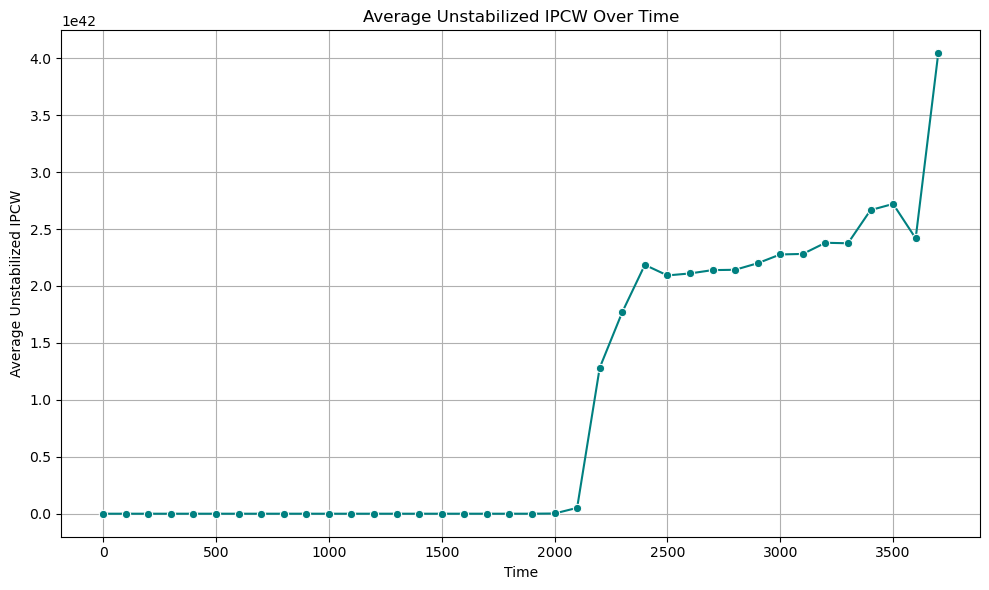

In [89]:
# upper_bound = df["UnstabIPCW_it"].quantile(0.01)
# lower_bound = df["UnstabIPCW_it"].quantile(0.95)
# df["UnstabIPCW_it"] = df["UnstabIPCW_it"].clip(lower=lower_bound, upper=upper_bound)

ipcw_over_time = df.groupby("tend")["UnstabIPCW_it"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=ipcw_over_time, x="tend", y="UnstabIPCW_it", marker="o", color='teal')
plt.xlabel("Time")
plt.ylabel("Average Unstabilized IPCW")
plt.title("Average Unstabilized IPCW Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
df["UnstabIPCW_it"].describe()

count    1.917500e+04
mean     6.344504e+49
std      5.796644e+50
min      1.116934e+01
25%      3.960055e+04
50%      1.305296e+11
75%      9.530484e+23
max      5.653858e+51
Name: UnstabIPCW_it, dtype: float64

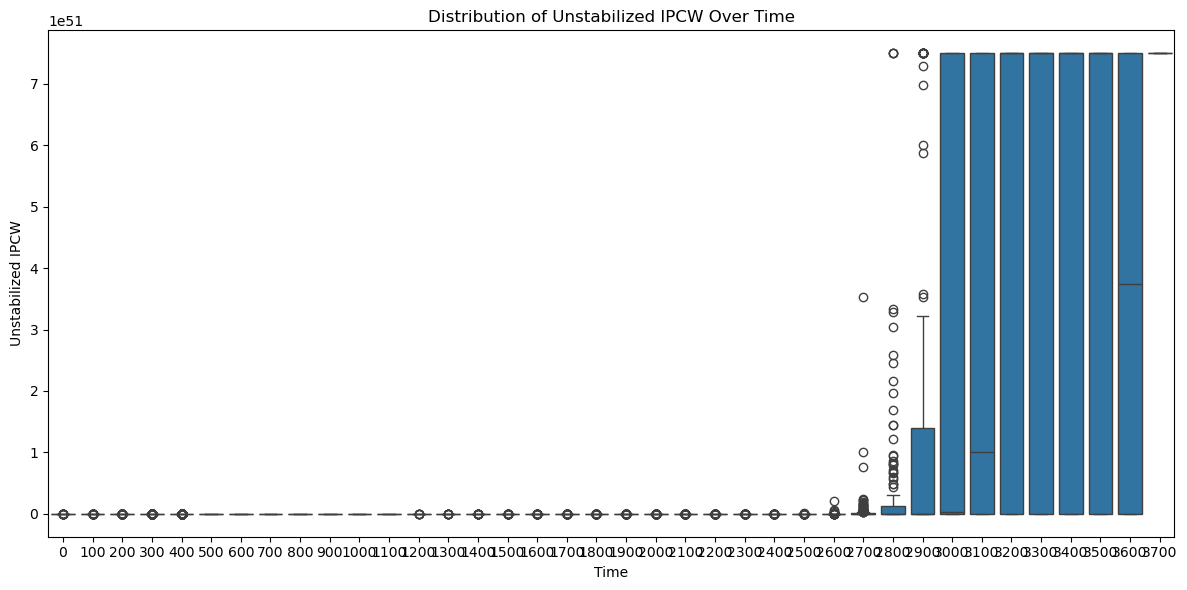

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="tend", y="UnstabIPCW_it")
plt.xlabel("Time")
plt.ylabel("Unstabilized IPCW")
plt.title("Distribution of Unstabilized IPCW Over Time")
plt.tight_layout()
plt.show()

I plan to use model avaraging for probabilities